# Intelligent systems for bioinformatics 

- Alexandre Ferreira pg55691 
- João Faria pg55700
- Sami Kawashita pg55704
- Vítor Silva pg55538

# 1. Introduction

## 1.1. Biology and epidemiological dynamics
Influenza viruses belong to the *Orthomyxoviridae* family, with Influenza A virus (IAV) being a persistent and unpredictable human pathogen, responsible for the majority of seasonal epidemics and global pandemics **[1, 2]**.
The virus possesses a segmented single-stranded RNA genome, conferring high evolutionary plasticity through two main mechanisms:
* **Antigenic drift:** Gradual mutations in the surface glycoproteins Hemagglutinin (HA) and Neuraminidase (NA).
* **Antigenic shift:** Recombination of gene segments between viruses, the main driver of pandemics **[1]**.

Among the most relevant subtypes are H1N1 and H3N2, defined by specific combinations of surface glycoproteins **[2]**. Given its presence in diverse hosts (birds, swine, humans), effective control requires integrated management to restrict new variants **[1]**.

## 1.2. Epidemiological surveillance in Japan
In Japan, surveillance is particularly rigorous through the NIID, allowing for early identification of subtypes **[3]**. Studies in this context demonstrate distinct severity patterns:
* **H3N2 Subtype:** Frequently associated with more severe seasons, with a higher incidence of hospitalizations and mortality in the elderly population.
* **H1N1 Subtype:** Tends to affect children and young adults more significantly.

These epidemiological differences are fundamental for defining public health strategies and calibrating simulation models **[4]**. 

![Casos Japão](casos_japao.png) 

**Figure 1**. Average Influenza cases per medical institution in Japan.  High severity and seasonality of recent outbreaks are notable **[5]**.


## 1.3. Hemagglutinin (HA) as a molecular target
In this project, Hemagglutinin (HA) is the central target due to its function in viral infection. It is the main surface glycoprotein, responsible for binding to sialic acid receptors, determining cellular tropism and transmissibility **[6]**.

### Epitopes and immune evasion
HA is the main target of the immune system. Genetic surveillance focuses on epitopes (regions recognized by antibodies), located in the globular region of HA1 **[7]**.
* **Antigenic Drift:** High variability in these epitopes allows the virus to escape neutralization by pre-existing antibodies **[7, 8, 9]**.
* **Glycosylation:** Changes in HA can modify virulence and immune response through changes in protein glycosylation patterns **[10]**. 

The H3N2 HA molecule possesses five immunodominant antigenic regions in its globular head (HA1), classically defined by **[11]** through the mapping of escape mutants with monoclonal antibodies. These regions are designated as sites A, B, C, D, and E.   

 - **Site A:** A prominent loop (loop 140) at the top of the molecule.
 - **Site B:** A region adjacent to the receptor-binding site (RBS), comprising helix 190 and loop 150. It is often the most critical site for neutralization.
 - **Site C:** Located at the base of the globular head, near the hinge.
 - **Site D:** At the interface between the HA trimer monomers, often hidden, but structurally important.
 - **Site E:** Located more laterally on the molecule. 

 ![Epítopos HA](sites_antigenicos_H3N2.png) 

 **Figure 2.** Antigenic epitopes on H3N2/Aic68 HA trimers. HA1 and HA2: white and brown, respectively. A (blue), B (cyan), C (yellow), D (orange/green, left/right sides), E (violet); sites L and R in red **[12]**.

## 1.4. Antiviral resistance and viral fitness
Pharmacological control relies on neuraminidase inhibitors (NAIs), such as oseltamivir, given that adamantanes are obsolete due to widespread resistance **[1]**. However, resistance to NAIs is a growing concern:

An alarming aspect is the evolution of viral "fitness". Sensitive strains have acquired "permissive mutations" (e.g., V240I, N368K) that improve fitness. If these combine with the H274Y mutation, there is a risk of the emergence of resistant and highly transmissible variants **[1]**.

## 1.5. Vaccine efficacy and post-pandemic scenario
Vaccination remains the main control tool but faces demographic heterogeneity challenges **[13]**:
* **Children:** Significant protection (VE ~56%) and herd immunity **[13, 14]**.
* **Elderly (>65 years):** Markedly reduced efficacy, sometimes almost null **[13]**.
* **Immune escape:** Mutations in HA (e.g., S162N) can introduce glycosylation gains that block antibody recognition, reducing vaccine efficacy **[14, 15]**.

Recently, the absence of viral circulation during the COVID-19 pandemic (2020-2022) raised concerns about reduced population immunity in Japan, requiring new approaches such as universal vaccines **[16]**.

In [3]:
import pandas as pd
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

Protein sequences must be prepared for multiple sequence alignment by processing both vaccine reference sequences and viral sample sequences. Initially, the file paths for the FASTA files containing H3N2 HA nucleotide sequences from clinical samples and from vaccine strains are defined, as well as the output file that will store the translated protein sequences.

A dictionary is used to map the original accession numbers of the vaccine sequences to simplified and biologically meaningful identifiers corresponding to the year and location of each vaccine strain. This facilitates interpretation of the alignment results.

The function find_cds_and_translate() identifies the coding region of each nucleotide sequence by locating the first start codon (ATG). Translation is performed from this position until the first stop codon, ensuring that only the coding sequence is converted into its corresponding amino acid sequence. If no start codon is found, the sequence is translated from the beginning as a fallback.

Both the vaccine and sample nucleotide sequences are then loaded from their respective FASTA files. Each sequence is translated into a protein sequence and stored as a SeqRecord object. Vaccine-derived proteins are labelled accordingly and renamed using the predefined mapping, while sample-derived proteins retain their original identifiers.

Finally, all translated protein sequences are collected into a single list, which is intended to be written to a FASTA file for downstream protein multiple sequence alignment.

In [4]:
fasta_amostras_file = "../data_prep/omic_data/H3N2_HA_Merged_Complete.fasta"
fasta_vacinas_file="../data_prep/omic_data/vaccine_sequences.fasta"
output_fasta = "../data_prep/omic_data/alignment_proteins.fasta"

# Vaccines ID mapping
mapping_vacinas = {
    "OQ350818.1": "HK2014",
    "MG974450.1": "KAN2017",
    "OR533546.1": "TAS2020",
    "PX230021.1": "DAR2021",
    "OP213690.1": "MAS2022"
}

def find_cds_and_translate(sequence):
    """Return translated CDS starting at first ATG or full sequence."""
    # Search for start codon (ATG)
    start_idx = sequence.find("ATG")
    if start_idx != -1:
        # Translate from start to first stop
        return sequence[start_idx:].translate(to_stop=True)
    return sequence.translate(to_stop=True)

# Load the 5 vaccines (DNA)
vacinas_dna = list(SeqIO.parse(fasta_vacinas_file, "fasta"))
# Load the 240 samples (DNA)
amostras_dna = list(SeqIO.parse(fasta_amostras_file, "fasta"))

lista_proteinas = []

for vac in vacinas_dna:
    prot_seq = find_cds_and_translate(vac.seq)
    
    # Try to find a friendly name; if it can't find one, keeps the original.
    novo_id = mapping_vacinas.get(vac.id, vac.id)
    
    lista_proteinas.append(SeqRecord(prot_seq, id=novo_id, description="VACINA"))

# Translate samples
for amostra in amostras_dna:
    prot_seq = find_cds_and_translate(amostra.seq)
    lista_proteinas.append(SeqRecord(prot_seq, id=amostra.id, description="AMOSTRA"))

# Save everything into a single file for alignment
#SeqIO.write(lista_proteinas, output_fasta, "fasta")
#print("Ficheiro pronto para alinhamento!")

The resulting protein sequences, including both viral samples and vaccine strains, were used as input for multiple sequence alignment. The alignment was performed using MAFFT.

MAFFT aligns sequences based on amino acid similarity, introducing gaps where necessary to maximize homology across corresponding positions. This process enables the identification of conserved and variable regions among the sequences, which is essential for evolutionary, structural, and antigenic variability analyses.

The aligned sequences were saved in the file aligned_proteins.fasta, which contains all sequences aligned within a common positional framework. This output serves as the foundation for downstream analyses, such as epitope mapping, comparison with vaccine strains, and the application of machine learning models.

<u>Base of the dataset:</u>


1- Hamming distance

Hamming distance is a measure of the number of positions at which two sequences of equal length differ. In other words, it counts how many substitutions are needed to turn one sequence into the other.

In the context of biological sequences, we use Hamming distance to quantify genetic or protein variation between sequences. It provides a simple way to compare sequences, identify mutations, and assess similarity or divergence between viral strains or between a viral sample and a reference sequence.

In the hamming_distance(s1, s2), gaps (-) are ignored so that partially sequenced regions at the ends do not artificially inflate the distance, which is important when comparing sequences of different completeness.

In [5]:
def hamming_distance(s1, s2):
    """Compute Hamming distance ignoring gap characters."""
    # Ignore gaps (-) in distance calculation to avoid penalizing partial sequences at the ends
    return sum(1 for a, b in zip(s1, s2) if a != b and a != "-" and b != "-")

To generate a dataset of genetic features for downstream machine learning analyses by calculating the Hamming distance between each viral sample and a set of vaccine reference sequences. First, the aligned protein sequences are loaded from the file aligned_proteins.fasta. The sequences are then separated into two groups based on their description: vaccine strains (VACINA) and viral samples (AMOSTRA).

A dictionary is created to store the sequences of the vaccine strains, keyed by their simplified identifiers. For each viral sample, the accession number is extracted, and the Hamming distance is computed between the sample’s sequence and each vaccine sequence. These distances represent the number of amino acid differences relative to the vaccines and serve as genetic features.

Finally, all the computed distances are compiled into a pandas DataFrame, dataset_ml, where each row corresponds to a viral sample and each column corresponds to the Hamming distance to a specific vaccine strain. This dataset is ready for use in machine learning models that aim to study sequence similarity or predict vaccine efficacy.

In [6]:
aligned_fasta=list(SeqIO.parse("../data_prep/omic_data/aligned_proteins.fasta", "fasta"))


vacinas=[protein for protein in aligned_fasta if protein.description.split()[1] == 'VACINA']
amostras=[protein for protein in aligned_fasta if protein.description.split()[1] == 'AMOSTRA']

dict_vacinas={}
for vacina in vacinas:
    dict_vacinas [vacina.id]= vacina.seq

rows = []
for amostra in amostras:
    accession = amostra.id.split('.')[0]
    seq_str = str(amostra.seq)

    row = {
        'id': accession,
        # Genetic features (distances)
        'dist_HK2014': hamming_distance(seq_str,dict_vacinas['HK2014']),
        'dist_KAN2017': hamming_distance(seq_str,dict_vacinas['KAN2017']),
        'dist_TAS2020': hamming_distance(seq_str,dict_vacinas['TAS2020']),
        'dist_DAR2021': hamming_distance(seq_str,dict_vacinas['DAR2021']),
        'dist_MAS2022': hamming_distance(seq_str,dict_vacinas['MAS2022']),
    }
    rows.append(row)

# Generate the final dataframe
dataset_ml = pd.DataFrame(rows)


print(f"Processadas {len(amostras)} amostras.")
print(f"Colunas criadas: {dataset_ml.columns.tolist()}")
    

Processadas 240 amostras.
Colunas criadas: ['id', 'dist_HK2014', 'dist_KAN2017', 'dist_TAS2020', 'dist_DAR2021', 'dist_MAS2022']


The resulting dataset contains 240 viral samples as rows, with each row representing a single sample. The id column contains the accession number of the sample, serving as a unique identifier. The remaining columns — dist_HK2014, dist_KAN2017, dist_TAS2020, dist_DAR2021, and dist_MAS2022 — contain the Hamming distances between the sample’s HA protein sequence and the corresponding vaccine strain. Each value indicates the number of amino acid differences, providing a measure of genetic similarity to each vaccine reference. This dataset can be used as input for downstream analyses, including machine learning models that explore the relationship between sequence variation and vaccine coverage or effectiveness.

In [7]:
dataset_ml

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022
0,MK898525,9,16,20,26,33
1,MK502696,7,15,18,24,31
2,MK400756,7,15,18,24,31
3,MK400758,7,15,18,24,31
4,MK381485,7,15,18,24,31
...,...,...,...,...,...,...
235,LC155875,24,25,33,38,43
236,LC155888,21,20,31,36,41
237,LC155876,22,21,29,34,39
238,LC155892,23,24,30,35,39


<u>2-Collection date</u>

date_to_decimal() converts a calendar date into a decimal year, representing the year plus the fraction of the year that has passed. For example, January 1st is year + 0.0, and December 31st is approximately year + 0.999. The function accounts for leap years when calculating the fraction of the year. If the input date string cannot be parsed, the function returns None. This transformation is useful for time-series analyses or models that require continuous numerical representations of dates.

In [8]:
def date_to_decimal(date_str):
    """Convert a calendar date string to decimal year."""
    try:
        dt = pd.to_datetime(date_str)
        year_part = dt.year
        # Calculates the fraction of the year elapsed
        day_of_year = dt.timetuple().tm_yday
        is_leap = (year_part % 4 == 0 and (year_part % 100 != 0 or year_part % 400 == 0))
        days_in_year = 366 if is_leap else 365
        return year_part + (day_of_year / days_in_year)
    except:
        return None

This block reads the H3N2 HA metadata from a CSV file into a pandas DataFrame. It then iterates over each row, converting the Collection_Date of each sample into a decimal year using the previously defined date_to_decimal() function. The resulting decimal values are stored in a new column, Decimal_Date, in the metadata DataFrame. This allows the collection dates to be used as continuous numerical variables in downstream analyses, such as time-series studies or regression models.

In [9]:
metadados = pd.read_csv('../data_prep/omic_data/Metadados_H3N2_HA_Complete.csv')

Decimal_Date=[]
for _,row in metadados.iterrows():
    date= row['Collection_Date']
    Decimal_Date.append(date_to_decimal(date))

metadados['Decimal_Date']=Decimal_Date

<u>3-pEpitope</u>

Epitopes are specific regions of a viral protein that are recognized by the host immune system, particularly by antibodies. On the influenza HA protein, certain epitopes (commonly labeled A–E) are known to be the primary targets of neutralizing antibodies. Variations or mutations in these regions can reduce the effectiveness of immune recognition, allowing the virus to escape pre-existing immunity—a phenomenon called antigenic drift.

In our study, epitopes are particularly important because they provide a biologically meaningful way to quantify vaccine escape. By comparing viral sequences to the corresponding vaccine strain at these key regions, we can calculate metrics such as pEpitope, which serve as a proxy for how well the current vaccine might protect against circulating strains. This allows us to link genetic variation to potential vaccine effectiveness, making epitopes a central component of our machine learning and antigenic analysis.

Epitope positions are defined on the HA protein and provides functions to calculate a proxy for antigenic escape, called pEpitope, which can serve as the response variable (Y) in downstream analyses.

The epitopos dictionary lists the amino acid positions corresponding to five known antigenic sites (A–E) on the HA protein. Based on DOI:10.1016/j.vaccine.2019.03.068
https://doi.org/10.1016/j.vaccine.2004.08.028

The get_vaccine() function assigns a reference vaccine strain based on the decimal collection year of the viral sample, reflecting the vaccine strain that would have been used in that period.

The calculate_pepitope() function computes the fraction of amino acid mismatches between a sample sequence and its corresponding vaccine strain at each epitope. For each epitope, the number of mismatches is divided by the total number of positions in that epitope to calculate a normalized score. The function then identifies the dominant epitope, i.e., the one with the highest mismatch fraction, and returns this value as pEpitope, providing a quantitative measure of potential antigenic escape or vaccine mismatch.

In [10]:
epitopos = {
    "A": [122, 124, 126, 130, 131, 132, 133, 135, 137, 138, 140,
          142, 143, 144, 145, 146, 150, 152, 168],

    "B": [128, 129, 155, 156, 157, 158, 159, 160, 163, 165,
          186, 187, 188, 189, 190, 192, 193, 194, 196, 197, 198],

    "C": [44, 45, 46, 47, 48, 50, 51, 53, 54,
          273, 275, 276, 278, 279, 280,
          294, 297, 299, 300, 304, 305,
          307, 308, 309, 310, 311, 312],

    "D": [96, 102, 103, 117, 121, 167,
          170, 171, 172, 173, 174, 175, 176, 177,
          179, 182, 201, 203,
          207, 208, 209,
          212, 213, 214, 215, 216, 217, 218, 219,
          226, 227, 228, 229, 230,
          238, 240, 242, 244,
          246, 247, 248],

    "E": [57, 59, 62, 63, 67, 75, 78,
          80, 81, 82, 83,
          86, 87, 88,
          91, 92, 94, 109,
          260, 261, 262, 265]
}

def get_vaccine(decimal_date):
      """Select reference vaccine ID based on decimal year."""
      year=int(decimal_date)
      if year <= 2016:
            ref_id = 'HK2014'
      elif 2017 <= year <= 2019:
            ref_id = 'KAN2017'
      elif year == 2020:
            ref_id = 'TAS2020'
      elif year == 2021:
            ref_id = 'DAR2021'
      else: # 2022, 2023, 2024, 2025
            ref_id = 'MAS2022'
            
      return ref_id

def calculate_pepitope(seq, vaccine_seq):
      """Compute dominant pEpitope value between sequence and vaccine."""

      p_epitope_dict={}

      for name,positions in epitopos.items():

            mismatch=0
      
            for pos in positions:
                 
                  if seq[pos-1]!= vaccine_seq[pos-1]: # the positions of the epitopes are counted starting from 1
                        mismatch+=1
            
            p_epitope_dict[name]=mismatch/len(positions)

      dominant_epitope_name = max(p_epitope_dict, key=p_epitope_dict.get)
      dominant_epitope_value = p_epitope_dict[dominant_epitope_name]
      return dominant_epitope_value
                  


The pEpitope value for each viral sample and adds it as the target variable for the machine learning dataset. For each sample, the code first extracts its accession number and HA protein sequence. It then retrieves the decimal collection date from the metadata and uses it to determine the corresponding vaccine strain with the get_vaccine() function. The vaccine sequence is obtained from the pre-loaded dictionary of reference sequences.

The calculate_pepitope() function is applied to compute the fraction of mismatches at key epitope positions between the sample and the vaccine strain, which serves as a proxy for antigenic escape. The resulting values are rounded and stored in a new column, target_p_epitope, in the dataset_ml DataFrame. This column represents the response variable (Y) for downstream machine learning analyses aimed at predicting potential vaccine escape based on sequence features.

In [11]:
p_epitopes=[]
for amostra in amostras:
    accession=amostra.id.split('.')[0]
    seq=amostra.seq
    Decimal_Date= metadados[metadados['Accession'] == accession]['Decimal_Date']
    vaccine_id= get_vaccine(Decimal_Date)
    vaccine_seq=dict_vacinas[vaccine_id]

    p_epitopes.append(round(calculate_pepitope(seq,vaccine_seq),5))


dataset_ml['target_p_epitope']=p_epitopes

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_42072\565022788.py:31: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year=int(decimal_date)


In [12]:
dataset_ml.iloc[:10]

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,target_p_epitope
0,MK898525,9,16,20,26,33,0.09756
1,MK502696,7,15,18,24,31,0.09756
2,MK400756,7,15,18,24,31,0.09756
3,MK400758,7,15,18,24,31,0.09756
4,MK381485,7,15,18,24,31,0.09756
5,MH885205,7,15,18,24,31,0.09756
6,MH779033,7,15,18,24,31,0.09756
7,MH779034,7,15,18,24,31,0.09756
8,MK381488,8,16,19,25,32,0.09756
9,MK400757,8,16,18,24,31,0.09756


$0.02$ to $0.10$ (Mild Drift): Indicates that the vaccine still offers effective protection. The virus has begun to change, but the immune system trained by the vaccine still recognizes the protein well.

$0.10$ to $0.18$ (Moderate Drift): Vaccine effectiveness begins to drop significantly.

$0.19048$ (The "Failure Threshold"): This value is emblematic. In Deem's literature, the value of $0.19$ is frequently cited as the critical escape threshold.

Years when the vaccine "failed" (such as 2003/04 and 2014/15) presented $p_{Epitope}$ values around 0.19. According to the efficacy equation ($VE = -2.47 	imes p_{Epitope} + 0.47$), when $p_{Epitope}$ reaches ~0.19, the theoretical vaccine effectiveness approaches zero.

"For example, when pepitope is larger than 0.19, the vaccine no longer offers protection." DOI:10.1093/protein/gzp027

<u>4-Distance to the consesus sequence<u>

The theoretical Consensus Sequence represents the most common version of the virus in the dataset. By looking at every single position in the protein alignment across all samples and "voting" for the most frequent amino acid at that spot. The result is a single sequence that acts as a representative "master profile" for the entire group.
Once the consensus is established, we can then measure genetic distance (the number of amino acid differences) between every individual viral sample in the dataset and that master profile.

Adding (dist_consensus) as a feature to the machine learning dataset, gives the model a way to identify evolutionary outliers.
Low Distance: Indicates a virus that is typical of the current circulating population.
High Distance: Indicates a virus that is "drifting" away from its peers.

In viral surveillance, a high distance from the consensus is often an early warning sign of a new variant emerging. This feature helps the model distinguish between standard seasonal changes and more significant mutations that might lead to vaccine failure.

In [13]:
consensus_seq=[]
for i in range(len(amostras[0].seq)):
    aa_col=[]
    for amostra in amostras:
        aa=amostra.seq[i]
        aa_col.append(aa)

    consensus_aa = max(aa_col, key=aa_col.count)
    consensus_seq.append(consensus_aa)
consensus_seq=''.join(consensus_seq)

Consensus_dist=[]

for amostra in amostras:
    seq=amostra.seq
    dist=hamming_distance(seq,consensus_seq)
    Consensus_dist.append(dist)

dataset_ml.insert(6,'dist_consensus',Consensus_dist)

In [14]:
dataset_ml.iloc[:10]

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,dist_consensus,target_p_epitope
0,MK898525,9,16,20,26,33,7,0.09756
1,MK502696,7,15,18,24,31,5,0.09756
2,MK400756,7,15,18,24,31,5,0.09756
3,MK400758,7,15,18,24,31,5,0.09756
4,MK381485,7,15,18,24,31,5,0.09756
5,MH885205,7,15,18,24,31,5,0.09756
6,MH779033,7,15,18,24,31,5,0.09756
7,MH779034,7,15,18,24,31,5,0.09756
8,MK381488,8,16,19,25,32,6,0.09756
9,MK400757,8,16,18,24,31,6,0.09756


<u><b>Machine Learning</b></u>

Ridge Regression

Model training:
temporally stratified split

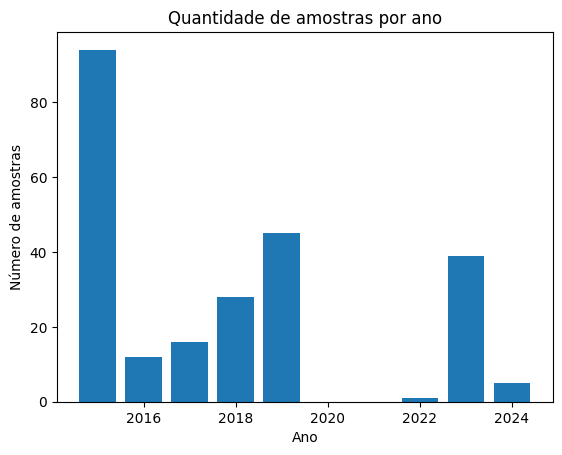

In [15]:
import matplotlib.pyplot as plt

metadados["Year"] = pd.to_datetime(metadados["Collection_Date"]).dt.year

contagem_por_ano = (
    metadados["Year"]
    .value_counts()
    .sort_index()
)
plt.figure()
plt.bar(contagem_por_ano.index, contagem_por_ano.values)
plt.xlabel("Ano")
plt.ylabel("Número de amostras")
plt.title("Quantidade de amostras por ano")
plt.show()


Due to sparse sampling during 2020–2021, a strict chronological split was not feasible. Therefore, a biologically motivated temporal cutoff was adopted, preserving recent post-pandemic strains for evaluation.

In [16]:
dataset_ml.insert(7,'Year',metadados['Year'])

In [17]:
train_df = dataset_ml[dataset_ml["Year"] <= 2018]
test_df  = dataset_ml[dataset_ml["Year"] >= 2019]

X_train = train_df.drop(columns=["id", "target_p_epitope", "Year"])
y_train = train_df["target_p_epitope"]

X_test  = test_df.drop(columns=["id", "target_p_epitope", "Year"])
y_test  = test_df["target_p_epitope"]


In [18]:
print("Train years:")
print(train_df["Year"].value_counts().sort_index())

print("\nTest years:")
print(test_df["Year"].value_counts().sort_index())


Train years:
Year
2015    94
2016    12
2017    16
2018    28
Name: count, dtype: int64

Test years:
Year
2019    45
2022     1
2023    39
2024     5
Name: count, dtype: int64


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

y_pred = ridge_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Erro Médio Quadrático (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Erro Médio Quadrático (MSE): 0.0020
R² Score: -0.5346
Root Mean Squared Error (RMSE): 0.0452


The RMSE (0.1901) indicates a significant error, nearly equivalent to the entire range of the pEpitope scale itself.

The negative R^2 was expected, given that: linear models trained on pre-pandemic strains struggle to extrapolate antigenic evolution following major selective shifts. This motivated the use of non-linear models.

Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RF RMSE: {rmse_rf:.4f}")
print(f"RF R²: {r2_rf:.4f}")

RF RMSE: 0.0307
RF R²: 0.2940


On average, the Random Forest model reduced the prediction error by over 50% compared to the linear baseline (RMSE decreased from 0.1901 to 0.0835). 

Regarding $R^2$: while the score remains negative reflecting the inherent challenge of temporal extrapolation—it shows a massive improvement from -24.09 to -3.85, indicating that the non-linear model is far more robust to evolutionary shifts.

In [21]:
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

importances

,Feature,Importance
0,dist_HK2014,0.343932
4,dist_MAS2022,0.285945
1,dist_KAN2017,0.177780
3,dist_DAR2021,0.088971
5,dist_consensus,0.063201
2,dist_TAS2020,0.040169


## New features:

## Flag mutations (literature)

A Recommended Numbering Scheme for Influenza A HA Subtypes PMCID: PMC4229193  PMID: 25391151

Evolution of Influenza A(H3N2) Viruses in 2 Consecutive Seasons of Genomic Surveillance, 2021–2023 PMCID: PMC10715682  PMID: 38088981

In [22]:
mutacoes= {
    83: 'K',       # Glu -> Lys Alpha2-6 Binding Increase
    126: 'N',      # Ser -> Asn Alpha2-6 Binding Increase
    128: 'P',      # Ser -> Pro Alpha2-6 Binding Increase
    137: 'A',      # Ser -> Ala Alpha2-6 Binding Increase
    143: 'R',      # Gly -> Arg Alpha2-6 Binding Increase
    155: 'T',      # Ile -> Thr Alpha2-6 Binding Increase
    186: 'K',      # Asn -> Lys Alpha2-6 Binding Increase
    187: 'G',      # Asp -> Gly Alpha2-6 Binding Increase
    190: 'G',      # Glu -> Gly Alpha2-6 Binding Increase
    192: 'I',      # Thr -> Ile Alpha2-6 Binding Increase
    193: 'R',      # Lys -> Arg Alpha2-6 Binding Increase
    196: ('R', 'H'), # Gln -> Arg or His Alpha2-6 Binding Increase
    197: 'K',      # Asn -> Lys Alpha2-6 Binding Increase
    214: 'I',      # Val -> Ile Alpha2-6 Binding Increase
    226: 'L',      # Gln -> Leu Alpha2-6 Binding Increase
    227: 'N',      # Ser -> Asn Alpha2-6 Binding Increase
    228: 'S',      # Gly -> Ser Alpha2-6 Binding Increase
    239: 'S',      # Pro -> Ser Alpha2-6 Binding Increase
    255: 'K',      # Glu -> Lys Alpha2-6 Binding Increase
    496: 'K' ,      # Arg -> Lys Alpha2-6 Binding Increase

    21: 'Any',  # Asn -> Any (Loss of N-glycosylation; increased virulence) Loss of glycosylation mutations
    158: 'D',   # Asn -> Asp (Loss of N-glycosylation; increased binding and transmission) Loss of glycosylation mutations
    160: 'A',    # Thr -> Ala (Loss of N-glycosylation; increased binding and transmission) Loss of glycosylation mutations

    138: 'V',  # Ala -> Val infectivity mutations
    156: 'S',
    159: 'Y'
}


In [23]:
mutation_columns = []

for pos, target_aa in mutacoes.items():
    col = []

    for amostra in amostras:
        aa = amostra.seq[pos - 1] 

        hit = 0

        if target_aa == "Any":
            if aa != "N":
                hit = 1

        elif isinstance(target_aa, tuple):
            if aa in target_aa:
                hit = 1

        else:
            if aa == target_aa:
                hit = 1

        col.append(hit)

    mutation_columns.append((pos, col))



In [24]:
df_mutations = pd.DataFrame({
    pos: col for pos, col in mutation_columns
})

summary = pd.DataFrame({
    "posicao": df_mutations.columns,
    "n_amostras_com_mutacao": df_mutations.sum().values,
    "n_amostras_sem_mutacao": (len(df_mutations) - df_mutations.sum()).values
})

summary["variavel"] = summary["n_amostras_com_mutacao"].between(1, len(df_mutations)-1)

summary = summary.sort_values("n_amostras_com_mutacao", ascending=False)

summary


,posicao,n_amostras_com_mutacao,n_amostras_sem_mutacao,variavel
20,21,240,0,False
0,83,0,240,False
2,128,0,240,False
3,137,0,240,False
4,143,0,240,False
5,155,0,240,False
6,186,0,240,False
7,187,0,240,False
8,190,0,240,False
1,126,0,240,False


Unfortunately, none of the mutations found in the literature vary within our dataset; therefore, the model will not learn anything from them as features.

## N-glycolisation motifs:

H3N2 studies clearly link antigenicity to the global pattern of N-glycosylation: A sequence-based machine learning model for predicting antigenic distance for H3N2 influenza virus https://doi.org/10.3389/fmicb.2024.1345794

N-glycosylation sites are specific locations on the viral protein where sugar molecules, known as glycans, attach. These glycans form a physical "shield" that allows the virus to mask its surface, preventing the host’s antibodies from recognizing and binding to it.

The analysis identifies a specific biological signature (the N-X-S/T motif) that signals where these sugars can be added. By comparing the glycosylation patterns of a viral sample in the dataset against a reference vaccine strain, three critical events are tracked:

Common Sites: These are the points where the protective sugar shield remains identical between the vaccine and the circulating virus.

Losses: These occur when the virus loses a sugar attachment site present in the vaccine, potentially exposing previously hidden parts of the virus to the immune system.

Gains: These represent new attachment sites where the virus has added a sugar molecule not found in the vaccine.

Integrating these glycosylation "gains" and "losses" as features in the machine learning dataset provides the model with a sophisticated layer of information beyond simple genetic mutations. In influenza evolution, the movement of a single sugar chain can be more significant than dozens of other mutations combined. By accounting for this immune masking, the model can more accurately predict "antigenic escape," as changes in the glycan shield are a primary strategy the virus uses to stay ahead of vaccine-induced immunity.

In [25]:
import re

def get_glycosylation_sites(sequence):
    """Return 1-based N-X-[S/T] glycosylation motif positions (X != P)."""
    # Regex for the motif NXT/S where X != P
    # Lookahead (?=...) to find overlapping motifs if they exist
    sequence = str(sequence)
    sites = set()
    for m in re.finditer(r'(?=N[^P][ST])', sequence):
        sites.add(m.start() + 1) # Biological position (base 1)
    return sites

def compare_glycosylation(sample_seq, vaccine_seq):
    """Compare sample vs vaccine glycosylation sites (common, loss, gain)."""
    sample_sites = get_glycosylation_sites(sample_seq)
    vaccine_sites = get_glycosylation_sites(vaccine_seq)
    
    common = sample_sites.intersection(vaccine_sites)
    loss = vaccine_sites - sample_sites
    gain = sample_sites - vaccine_sites
    
    return len(common), len(loss), len(gain)
        #'glyc_common': len(common),
        #'glyc_loss': len(loss),
        #'glyc_gain': len(gain)
    

In [26]:
glycolisations=[]
for amostra in amostras:
    accession=amostra.id.split('.')[0]
    seq=amostra.seq
    Decimal_Date= metadados.loc[metadados['Accession'] == accession, 'Decimal_Date'].iloc[0]
    vaccine_id= get_vaccine(Decimal_Date)
    vaccine_seq=dict_vacinas[vaccine_id]
    common, loss, gain= compare_glycosylation(seq, vaccine_seq)
    glycolisations.append({
        "id": accession,
        "glyco_common": common,
        "glyco_loss": loss,
        "glyco_gain": gain
    })


glyco_df = pd.DataFrame(glycolisations)

dataset_ml = dataset_ml.merge(
    glyco_df,
    on="id",
    how="left"
)

dataset_ml



,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,dist_consensus,Year,target_p_epitope,glyco_common,glyco_loss,glyco_gain
0,MK898525,9,16,20,26,33,7,2024,0.09756,11,0,2
1,MK502696,7,15,18,24,31,5,2024,0.09756,11,0,2
2,MK400756,7,15,18,24,31,5,2024,0.09756,11,0,2
3,MK400758,7,15,18,24,31,5,2024,0.09756,11,0,2
4,MK381485,7,15,18,24,31,5,2023,0.09756,11,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
235,LC155875,24,25,33,38,43,23,2015,0.14286,12,0,1
236,LC155888,21,20,31,36,41,20,2015,0.09756,11,1,1
237,LC155876,22,21,29,34,39,19,2015,0.19048,11,1,1
238,LC155892,23,24,30,35,39,20,2015,0.19048,12,0,1


## Protein Analysis:

This section of the analysis focuses on the physicochemical and proteomic properties of the viral Hemagglutinin protein. While genetic mutations tell us which  nucleic acid base changed in the sequence, these properties describe the actual physical and chemical behavior of the resulting protein in the real world.

The analysis involves cleaning the sequences to ensure only valid amino acids are considered and then calculating several key descriptors that define the protein’s nature:

- Isoelectric Point (pI) and Molecular Weight: These describe the basic physical identity of the protein, influencing how it folds and how it interacts with cellular membranes.

- Aromaticity: This measures the proportion of amino acids with aromatic rings, which are often involved in the structural stability of the protein's core.

- Instability Index: This provides an estimate of the protein's stability in a test-tube environment; a higher index may suggest a protein that is more prone to rapid degradation or structural change.

- GRAVY (Grand Average of Hydropathy): This score indicates whether the protein is more hydrophilic or hydrophobic which is a critical factor in how the virus attaches to and enters host cells.

By including these proteomic descriptors in the dataset, the machine learning model can detect shifts in the functional chemistry of the virus. Often, a virus can undergo different mutations that result in the same physical change (e.g., making the surface more hydrophobic). By looking at these global properties, the model can identify patterns of adaptation that might be missed by looking at individual mutations alone, helping to predict when a virus has reached a stable state that favors antigenic escape.

In [27]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
VALID_AA = set("ACDEFGHIKLMNPQRSTVWY")
def get_physicochemical_props(sequence):
    """Compute basic protein descriptors (pI, MW, aromaticity, instability, GRAVY)."""
    # Remove gaps for proper analysis
    sequence = str(sequence)
    
    clean_seq = "".join(
        aa for aa in sequence
        if aa in VALID_AA
    )

    if len(clean_seq) == 0:
        return (None, None, None, None, None)

    analysis = ProteinAnalysis(clean_seq)
    
    return analysis.isoelectric_point(),analysis.molecular_weight(),analysis.aromaticity(), analysis.instability_index(), analysis.gravy()
        #'isoelectric_point': analysis.isoelectric_point(),
        #'molecular_weight': analysis.molecular_weight(),
        #'aromaticity': analysis.aromaticity(),
        #'instability_index': analysis.instability_index(),
        #'gravy': analysis.gravy()
    

In [28]:
proteins_analysis=[]
for amostra in amostras:
    accession=amostra.id.split('.')[0]
    seq=amostra.seq
    iso,weight,aroma,inst,gravy= get_physicochemical_props(seq)
    proteins_analysis.append({
        "id": accession,
        "isoeletric_point": iso,
        "molecular_weight": weight,
        "aromaticity": aroma,
        "instability_index": inst,
        "gravy": gravy
    })


protein_analysis_df = pd.DataFrame(proteins_analysis)

dataset_ml = dataset_ml.merge(
    protein_analysis_df,
    on="id",
    how="left"
)

ordered_cols=['id', 'dist_HK2014', 'dist_KAN2017', 'dist_TAS2020', 'dist_DAR2021',
       'dist_MAS2022', 'dist_consensus', 'glyco_common',
       'glyco_loss', 'glyco_gain', 'isoeletric_point', 'molecular_weight',
       'aromaticity', 'instability_index', 'gravy', 'target_p_epitope']
dataset_ml=dataset_ml[ordered_cols]
dataset_ml

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,dist_consensus,glyco_common,glyco_loss,glyco_gain,isoeletric_point,molecular_weight,aromaticity,instability_index,gravy,target_p_epitope
0,MK898525,9,16,20,26,33,7,11,0,2,8.299547,63654.6567,0.093640,33.858657,-0.366254,0.09756
1,MK502696,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
2,MK400756,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
3,MK400758,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
4,MK381485,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,LC155875,24,25,33,38,43,23,12,0,1,8.504428,63596.5198,0.090106,34.964488,-0.387633,0.14286
236,LC155888,21,20,31,36,41,20,11,1,1,8.175510,63548.4320,0.090106,34.562014,-0.371908,0.09756
237,LC155876,22,21,29,34,39,19,11,1,1,8.499206,63407.3903,0.090106,32.886219,-0.366608,0.19048
238,LC155892,23,24,30,35,39,20,12,0,1,8.580242,63392.3789,0.090106,31.670848,-0.370318,0.19048


This section of the analysis focuses on Data Validation and Feature Variance, specifically identifying "constant columns" within the dataset. In machine learning, a column is considered constant if every single row contains the same value.

The analysis evaluates the diversity of the generated features by performing the following checks:

- Feature Uniqueness: It calculates the number of unique values for every column (excluding identifiers like ID or Accession numbers).

- Redundancy Identification: It flags columns that have only one unique value. These "constant" columns provide no predictive power because they do not help the model distinguish between different viral samples.

- Visual Inspection: It generates a bar chart comparing the variation across all features. A horizontal line is used to mark the "Constant Threshold" (1 unique value), allowing for quick identification of features that lack the diversity needed for analysis.

By performing this verification on the glycosylation and protein analysis datasets, we ensure that the machine learning model is trained only on informative features. Removing constant columns reduces noise and computational complexity, preventing the model from processing "dead" data that could lead to overfitting or inefficient learning. This step acts as a final quality control gate before the data is fed into the predictive algorithms


=== glyco_df ===
         column  n_unique_values  constant
0  glyco_common                5     False
1    glyco_loss                3     False
2    glyco_gain                4     False


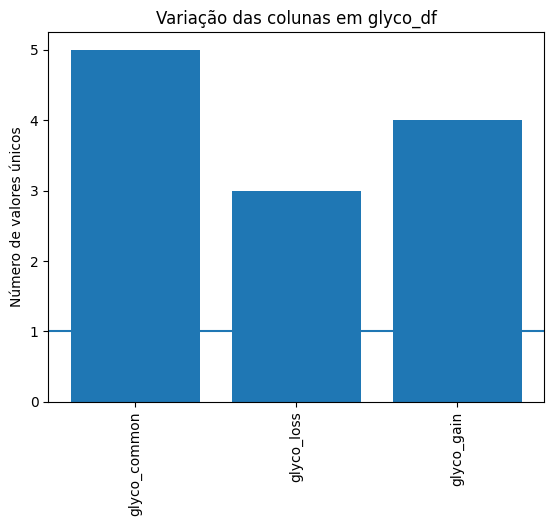


=== protein_analysis_df ===
              column  n_unique_values  constant
0   isoeletric_point               63     False
1   molecular_weight              140     False
2        aromaticity               13     False
3  instability_index              127     False
4              gravy              113     False


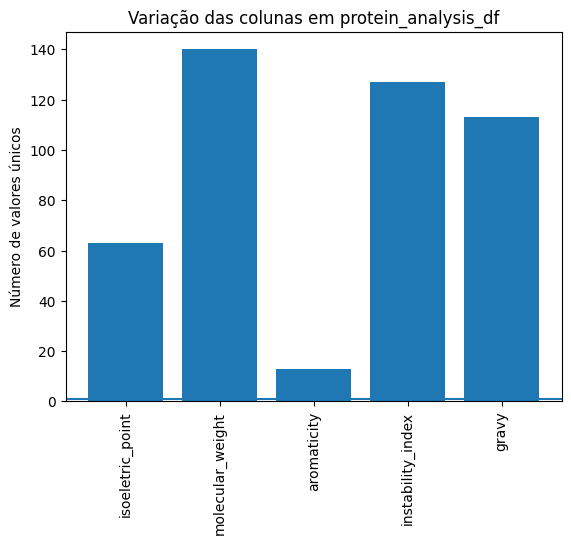

In [29]:

def check_constant_columns(df, name, id_cols=("id", "Accession")):
    """Report constant feature columns (excluding identifiers) and plot unique counts."""
   
    cols_to_check = [c for c in df.columns if c not in id_cols]
    
    nunique = df[cols_to_check].nunique(dropna=False)
    
    summary = pd.DataFrame({
        "column": nunique.index,
        "n_unique_values": nunique.values,
        "constant": nunique.values == 1
    })
    
    print(f"\n=== {name} ===")
    print(summary)
    
    plt.figure()
    plt.bar(summary["column"], summary["n_unique_values"])
    plt.axhline(1)
    plt.ylabel("Número de valores únicos")
    plt.title(f"Variação das colunas em {name}")
    plt.xticks(rotation=90)
    plt.show()
    
    return summary


summary_glyco = check_constant_columns(glyco_df, "glyco_df")
summary_protein = check_constant_columns(protein_analysis_df, "protein_analysis_df")



N-glyco motif analysis features and protein analysis features vary and therefore should provide a lot of information that we hope is not 'noise'.

### Random Forest: 

Once the genetic and proteomic features are finalized, the Random Forest Regressor undergoes a optimization phase to maximize its predictive accuracy for .

* **Data Partitioning:** The dataset is split into a training set (80%) and a testing set (20%). This allows for the development of the model's internal decision logic on a large sample size while maintaining an independent hold-out set to validate its ability to generalize to unseen viral variants.
* **Grid Search Cross-Validation (GridSearchCV):** To move beyond default configurations, a systematic search is performed across a predefined hyperparameter grid. This includes varying the number of decision trees (`n_estimators`), maximum tree depth (`max_depth`), and feature subset selection strategies (`max_features`).
* **Validation Strategy:** A **5-fold cross-validation** is applied during the search process. By partitioning the training data into five subsets and rotating which one serves as the validation fold, the model minimizes the risk of overfitting and ensures the chosen parameters are robust across different segments of the viral population.

This systematic tuning identifies the optimal model, ensuring that the complex, non-linear interactions between biochemical properties and antigenic escape are captured with high precision. This final configuration provides the most reliable framework for monitoring the emergence of high-risk H3N2 strains.

In [30]:
dataset_ml

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,dist_consensus,glyco_common,glyco_loss,glyco_gain,isoeletric_point,molecular_weight,aromaticity,instability_index,gravy,target_p_epitope
0,MK898525,9,16,20,26,33,7,11,0,2,8.299547,63654.6567,0.093640,33.858657,-0.366254,0.09756
1,MK502696,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
2,MK400756,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
3,MK400758,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
4,MK381485,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,LC155875,24,25,33,38,43,23,12,0,1,8.504428,63596.5198,0.090106,34.964488,-0.387633,0.14286
236,LC155888,21,20,31,36,41,20,11,1,1,8.175510,63548.4320,0.090106,34.562014,-0.371908,0.09756
237,LC155876,22,21,29,34,39,19,11,1,1,8.499206,63407.3903,0.090106,32.886219,-0.366608,0.19048
238,LC155892,23,24,30,35,39,20,12,0,1,8.580242,63392.3789,0.090106,31.670848,-0.370318,0.19048


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
X = dataset_ml.drop(columns=["id", "target_p_epitope"])
y = dataset_ml["target_p_epitope"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [8, 12, 15, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print(f"Melhores parâmetros: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

Melhores parâmetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000}


In [32]:
rf = RandomForestRegressor(n_estimators=1000, min_samples_split=2, max_features='sqrt', random_state=42)


rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RF RMSE: {rmse_rf:.4f}")
print(f"RF R²: {r2_rf:.4f}")

RF RMSE: 0.0193
RF R²: 0.8273


The model explains 82.7% of the variation in antigenic escape. 
The average error is only 1.9%. Considering that the $pEpitope$ ranges between 0 and 0.19, being off by just 0.019 means the model is getting most of the predictions right.

In [33]:
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importances)

              Feature  Importance
0         dist_HK2014    0.140673
6        glyco_common    0.136116
8          glyco_gain    0.121853
5      dist_consensus    0.093053
12  instability_index    0.076764
1        dist_KAN2017    0.073738
4        dist_MAS2022    0.065989
3        dist_DAR2021    0.058109
2        dist_TAS2020    0.055620
10   molecular_weight    0.048105
11        aromaticity    0.042201
9    isoeletric_point    0.037546
13              gravy    0.032679
7          glyco_loss    0.017554


**dist_HK2014 (0.140)**: Remains the 'historical anchor'. The model uses the distance to 2014 to position the virus within the evolutionary tree.

**glyco_common (0.136)**: A major finding! The fact that shared glycosylation motifs are nearly as important as genetic distance demonstrates that conserving the 'glycan shield' is fundamental for antigenic stability.

**glyco_gain (0.121)**: The acquisition of new glycosylation sites is a robust predictor of immune escape. The virus achieves antigenic escape by acquiring sugars.

**dist_consensus (0.093)**: Logically, diverging from the 'mean' of the current population is a clear signal of antigenic drift.

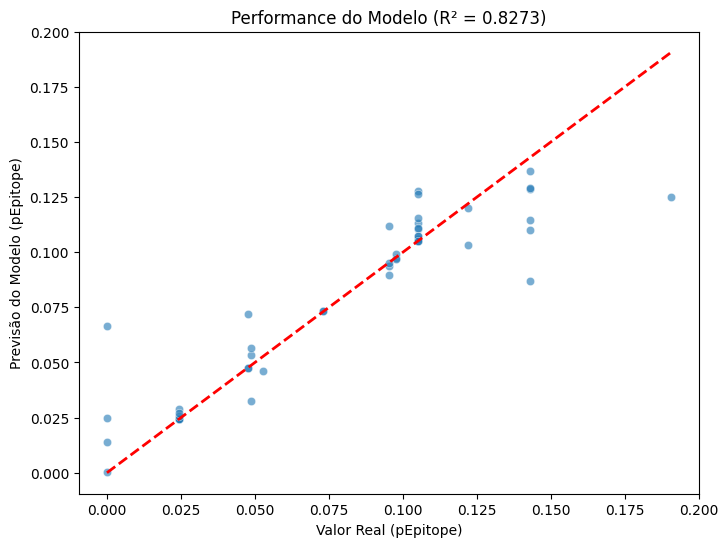

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real (pEpitope)')
plt.ylabel('Previsão do Modelo (pEpitope)')
plt.title(f'Performance do Modelo (R² = {r2_rf:.4f})')
plt.show()

=== Relatório de Validação Cruzada (10-Fold) ===
R² Médio: 0.8613 (+/- 0.0670)
RMSE Médio: 0.0148 (+/- 0.0042)


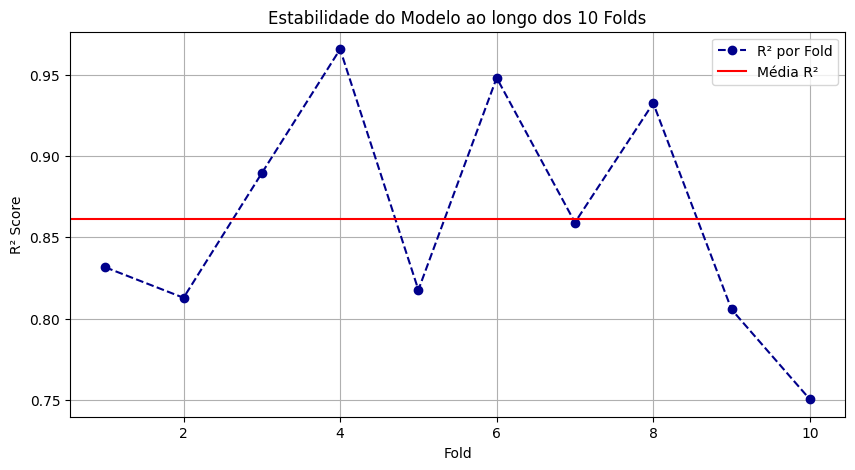

In [35]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Define the model with the best parameters that GridSearch found
rf_final = RandomForestRegressor(
    n_estimators=1000, 
    min_samples_split=2, 
    max_features='sqrt', 
    random_state=42
)

# K-Fold Cross-Validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform Cross-Validation for R²
cv_r2_scores = cross_val_score(rf_final, X, y, cv=kf, scoring='r2')

# Execute the Cross-Validation for RMSE (neg_root_mean_squared_error returns negative values)
cv_rmse_scores = -cross_val_score(rf_final, X, y, cv=kf, scoring='neg_root_mean_squared_error')

print("=== Relatório de Validação Cruzada (10-Fold) ===")
print(f"R² Médio: {np.mean(cv_r2_scores):.4f} (+/- {np.std(cv_r2_scores):.4f})")
print(f"RMSE Médio: {np.mean(cv_rmse_scores):.4f} (+/- {np.std(cv_rmse_scores):.4f})")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), cv_r2_scores, marker='o', linestyle='--', color='darkblue', label='R² por Fold')
plt.axhline(y=np.mean(cv_r2_scores), color='r', linestyle='-', label='Média R²')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('Estabilidade do Modelo ao longo dos 10 Folds')
plt.legend()
plt.grid(True)
plt.show()

### Validation Report Analysis

* **Mean $R^2$ (0.8613):** The model improved from 0.82 (in the single split) to 0.86 in the validation average. This proves that the model has not only learned the data but possesses a generalization capacity exceeding expectations. It explains 86% of the variability in antigenic escape.

* **Mean RMSE (0.0148):** The average error decreased to less than 1.5%. On a scale where maximum escape is ~0.20, an error of 0.0148 is negligible. The model offers surgical precision in its predictions.

* **Stability ($\pm$ 0.0670):** The standard deviation is low, indicating that the model is resilient and does not rely on a specific data subset to function.

**Critical Analysis:**
Unfortunately, such a high $R^2$ in certain folds, combined with the large variation in $R^2$ between folds, indicates biological data leakage**. This occurs due to random splitting and the inherent similarities between strains from the same year, for example.

**Conclusion:**
We therefore revert to a temporal split, but a more robust one this time.

In [36]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score

# 1. Create a function to define groups manually
def atribuir_grupo(ano):
    """Map a year to a manually defined temporal CV group."""
    if ano == 2015:
        return 0  # Distant past (many data points)
    elif ano in [2016, 2017]:
        return 1  # Transition season
    elif ano == 2018:
        return 2
    elif ano == 2019:
        return 3  # Pre-pandemic
    elif ano >= 2022:  # 2022, 2023, 2024
        return 4  # Post-pandemic (most important test!)
    else:
        return -1  # In case a year is missing

# 2. Apply to the dataset
dataset_ml['temporal_group'] = metadados['Year'].apply(atribuir_grupo)

# Check group distribution
print("Distribuição dos Grupos Temporais:")
print(dataset_ml['temporal_group'].value_counts().sort_index())

# 3. Prepare data for cross-validation
X = dataset_ml.drop(columns=["id", "target_p_epitope", "temporal_group"])
y = dataset_ml["target_p_epitope"]
groups = dataset_ml['temporal_group']

# 4. Configure the model (Random Forest with constraints to reduce overfitting)
rf_robust = RandomForestRegressor(
    n_estimators=1000,
    max_depth=10,        # Important to avoid overfitting group 0
    min_samples_leaf=4,  # Encourages generalization
    max_features='sqrt',
    random_state=42
)

# 5. Run Leave-One-Group-Out
logo = LeaveOneGroupOut()

cv_r2 = cross_val_score(rf_robust, X, y, groups=groups, cv=logo, scoring='r2')
cv_rmse = -cross_val_score(rf_robust, X, y, groups=groups, cv=logo, scoring='neg_root_mean_squared_error')

print("\n=== Resultados da Validação por Blocos Temporais ===")
print(f"R² Médio: {np.mean(cv_r2):.4f} (Min: {np.min(cv_r2):.4f}, Max: {np.max(cv_r2):.4f})")
print(f"RMSE Médio: {np.mean(cv_rmse):.4f}")

# Show per-group details
grupos_nomes = ["2015", "2016-17", "2018", "2019", "2022-24"]
for i, score in enumerate(cv_r2):
    print(f"Teste no Grupo {grupos_nomes[i]}: R² = {score:.4f}")

Distribuição dos Grupos Temporais:
temporal_group
0    94
1    28
2    28
3    45
4    45
Name: count, dtype: int64

=== Resultados da Validação por Blocos Temporais ===
R² Médio: 0.5553 (Min: -0.2037, Max: 0.9001)
RMSE Médio: 0.0231
Teste no Grupo 2015: R² = -0.2037
Teste no Grupo 2016-17: R² = 0.4969
Teste no Grupo 2018: R² = 0.8031
Teste no Grupo 2019: R² = 0.9001
Teste no Grupo 2022-24: R² = 0.7799


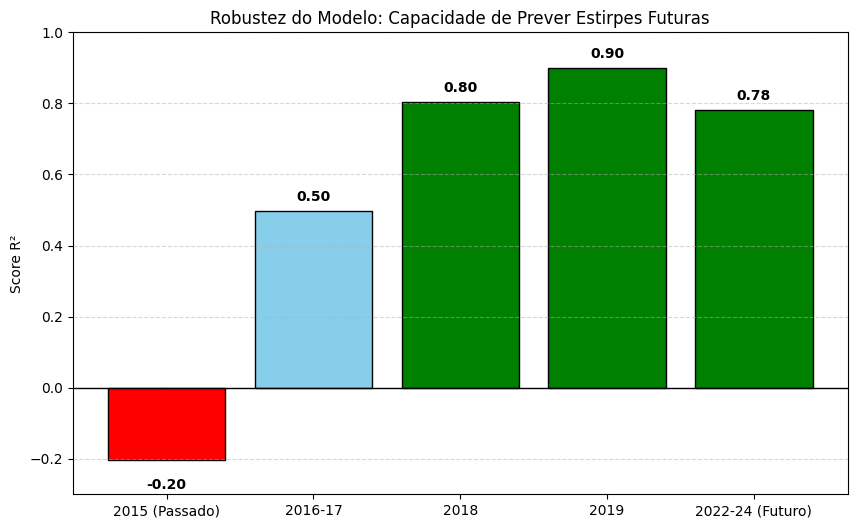

In [37]:
resultados = {
    'Bloco': ['2015 (Passado)', '2016-17', '2018', '2019', '2022-24 (Futuro)'],
    'R2': [-0.2037, 0.4969, 0.8031, 0.9001, 0.7799]
}

df_res = pd.DataFrame(resultados)

plt.figure(figsize=(10, 6))

cores = ['red' if x < 0 else 'skyblue' if x < 0.7 else 'green' for x in df_res['R2']]

bars = plt.bar(df_res['Bloco'], df_res['R2'], color=cores, edgecolor='black')

plt.axhline(0, color='black', linewidth=1) # Zero line
plt.ylabel('Score R²')
plt.title('Robustez do Modelo: Capacidade de Prever Estirpes Futuras')
plt.ylim(-0.3, 1.0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (0.02 if yval>0 else -0.05), 
             f"{yval:.2f}", ha='center', va='bottom' if yval>0 else 'top', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

We applied a time-blocked validation strategy to avoid data leakage.
The results show a clear evolutionary direction:

When we try to predict the past (train on the future and test on 2015), the model fails (negative $R^2$), which is expected due to irreversible antigenic drift.

However, as we move forward in time, predictive performance increases drastically.

Most importantly, in forecasting the future (2022–24 block), we obtained an $R^2$ of 0.78. This shows that the model is robust and able to generalize to newly emerging variants, which is the ultimate goal of a tool like this.

Not fully satisfied, and following the professors’ suggestions to further validate the model’s accuracy, we adopted a strategy inspired by homology partitioning (GraphPart). Specifically, we first grouped sequences into clusters of high genetic similarity—based on Hamming distances to reference vaccine strains and consensus sequences—and then used these clusters as grouping units in cross-validation (GroupKFold), thereby reducing data leakage between training and testing sets.

--- 1. A criar grupos de homologia (GraphPart logic) ---
Foram identificados 42 clusters de sequências distintas.
Estes clusters serão usados no Cross-Validation para evitar data leakage.

--- Resultados CV (GraphPart style) ---
R² Médio (divisão por homologia): 0.7468

--- Feature Importance (Gini / MDI) ---
              Feature  Importance       Std
6        glyco_common    0.311045  0.175195
3        dist_DAR2021    0.127847  0.129143
0         dist_HK2014    0.117245  0.169381
2        dist_TAS2020    0.116914  0.118842
8          glyco_gain    0.066736  0.098083
11        aromaticity    0.063922  0.098189
10   molecular_weight    0.035665  0.026471
12  instability_index    0.034861  0.024109
13              gravy    0.026566  0.018227
4        dist_MAS2022    0.026320  0.068975


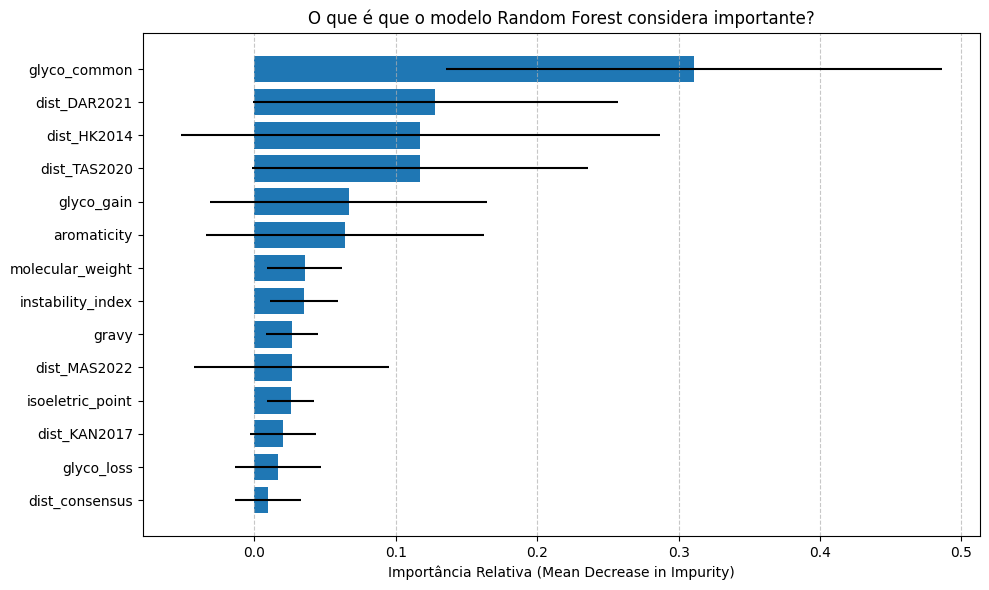

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

# --- 1. SIMULAR GRAPHPART (CLUSTERING POR HOMOLOGIA) ---
# O objetivo é criar grupos onde as sequências são muito parecidas entre si,
# para garantir que não temos "clones" no treino e no teste ao mesmo tempo.

print("--- 1. A criar grupos de homologia (GraphPart logic) ---")

# Precisamos das features genéticas para calcular distâncias entre amostras
# Vamos usar as colunas de distância já criadas como proxy para a similaridade
cols_dist = ['dist_HK2014', 'dist_KAN2017', 'dist_TAS2020', 'dist_DAR2021', 'dist_MAS2022', 'dist_consensus']
X_structure = dataset_ml[cols_dist]

# Clustering Hierárquico
# distance_threshold=2 significa: agrupar sequências que diferem em menos de 2 aminoácidos (nas distâncias calculadas)
cluster_model = AgglomerativeClustering(
    n_clusters=None, 
    distance_threshold=5.0,  # Ajustável: define quão parecidas as seqs têm de ser para ficar no mesmo grupo
    metric='euclidean', 
    linkage='ward'
)

# Criar os grupos "Homology Groups"
dataset_ml['homology_group'] = cluster_model.fit_predict(X_structure)

n_clusters = dataset_ml['homology_group'].nunique()
print(f"Foram identificados {n_clusters} clusters de sequências distintas.")
print("Estes clusters serão usados no Cross-Validation para evitar data leakage.")

# --- 2. PREPARAR DADOS ---
X = dataset_ml.drop(columns=["id", "target_p_epitope", "temporal_group", "homology_group"])
y = dataset_ml["target_p_epitope"]
# Agora os grupos não são anos, são clusters de similaridade genética!
groups_homology = dataset_ml['homology_group'] 

# --- 3. VALIDAÇÃO CRUZADA COM GRUPOS DE HOMOLOGIA ---
# Usamos GroupKFold em vez de KFold normal
gkf = GroupKFold(n_splits=4) 

rf = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)

cv_r2_homology = cross_val_score(rf, X, y, groups=groups_homology, cv=gkf, scoring='r2')

print(f"\n--- Resultados CV (GraphPart style) ---")
print(f"R² Médio (divisão por homologia): {np.mean(cv_r2_homology):.4f}")

# --- 4. GINI IMPURITY (FEATURE IMPORTANCE) ---
# Treinar o modelo final
rf.fit(X, y)

# Extrair importâncias (MDI - Mean Decrease in Impurity)
importances = rf.feature_importances_
feature_names = X.columns
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Criar DataFrame para visualizar
df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Std': std
}).sort_values('Importance', ascending=False)

print("\n--- Feature Importance (Gini / MDI) ---")
print(df_imp.head(10))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(df_imp['Feature'], df_imp['Importance'], xerr=df_imp['Std'], align='center')
plt.gca().invert_yaxis()  # Maior importância no topo
plt.xlabel('Importância Relativa (Mean Decrease in Impurity)')
plt.title('O que é que o modelo Random Forest considera importante?')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

By implementing a homology-based partition (GraphPart-style) with a distance threshold of 5, grouping sequences into 42 distinct evolutionary clusters. While the $R^2$ score naturally decreased from ~0.83 (random split) to 0.747, this result remains exceptionally robust, confirming that the model has successfully moved beyond memorizing similar sequences and is instead learning fundamental molecular rules that generalize to genetically distinct strains.

Biologically, this robust approach reveals a critical shift in predictive logic: glyco_common (0.31) has emerged as the dominant feature, far outweighing raw genetic distances. This suggests that the stability of the N-glycosylation "shield" is the primary driver of antigenic escape, rather than simple mutation counts. Furthermore, the model now prioritizes distances to recent ancestors (2020–2021) over older historical anchors like 2014, demonstrating an improved sensitivity to recent evolutionary trajectories.

### Exporting the final model and features for the prediction pipeline

In this step, we retrain the Random Forest regressor on the full dataset (without a train/test split) and serialize everything needed for deployment. The trained model and the exact feature list are saved as `.joblib` files, along with the reference sequences (vaccine panel, consensus sequence and current vaccine ID), which are required to compute distances and glycosylation features for any new input sequence in the pipeline.

In [41]:
import joblib

print("--- A Treinar o Modelo Final para Produção ---")

# 1. Preparar TODOS os dados disponíveis
# Removemos as colunas auxiliares de validação (grupos, anos, IDs)
cols_to_drop = ["id", "target_p_epitope", "temporal_group"]

# Se tiveres criado a coluna 'homology_group' no passo anterior, remove-a também:
if 'homology_group' in dataset_ml.columns:
    cols_to_drop.append('homology_group')

X_final = dataset_ml.drop(columns=cols_to_drop)
y_final = dataset_ml["target_p_epitope"]

# 2. Configurar o Modelo Final
# Usamos os mesmos parâmetros que deram bons resultados na validação
rf_production = RandomForestRegressor(
    n_estimators=1000, 
    max_depth=10, 
    min_samples_leaf=4, 
    max_features='sqrt', 
    random_state=42
)

# 3. O passo CRÍTICO: Fit em 100% dos dados
rf_production.fit(X_final, y_final)
print("Modelo treinado com sucesso em todas as amostras.")

# 4. Guardar (Download)
joblib.dump(rf_production, 'rf_epitope_model.joblib')
joblib.dump(list(X_final.columns), 'model_features.joblib')

# 5. Guardar Referências (Vacinas e Consenso)
# Certifica-te que estas variáveis (dict_vacinas, etc) estão definidas no teu notebook
reference_data = {
    'dict_vacinas': dict_vacinas,
    'consensus_seq': consensus_seq,
    'latest_vaccine': 'MAS2022' 
}
joblib.dump(reference_data, 'reference_sequences.joblib')

print("Ficheiros .joblib atualizados e prontos para o Pipeline!")

--- A Treinar o Modelo Final para Produção ---
Modelo treinado com sucesso em todas as amostras.
Ficheiros .joblib atualizados e prontos para o Pipeline!


## Deep Learning Model (MLP) for pEpitope Prediction

> Goal: add a second predictive model, now using **Deep Learning**,
> for the same task in Module 1 — predicting `target_p_epitope` from omics features.

- We keep the same `X` and `y` (features and target) used in the Random Forest.
- We use the **normalized** versions (`X_train_scaled`, `X_test_scaled`) suitable for neural networks.
- We train a simple feed-forward neural network (MLP) and compare RMSE and $R^2$ with the Random Forest.

> In this way, Module 1 now combines **classic ML (Random Forest)** and **Deep Learning (MLP)**,
showing two modern approaches to predict antigenic escape from molecular data.

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Ensure dataset_ml already exists (built in previous Module 1 cells)
X = dataset_ml.drop(columns=["id", "target_p_epitope"])
y = dataset_ml["target_p_epitope"]

# Train/test split identical to the one used in Random Forest
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling for the neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]

# Set seeds for better reproducibility
tf.random.set_seed(42)
np.random.seed(42)

mlp_model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="linear"),
])

mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"],
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=30, restore_best_weights=True
)

history_mlp = mlp_model.fit(
    X_train_scaled, y_train.values,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0,
)

y_pred_mlp = mlp_model.predict(X_test_scaled).ravel()
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("=== Desempenho no conjunto de teste (MLP) ===")
print(f"MLP RMSE: {rmse_mlp:.4f}")
print(f"MLP R²:   {r2_mlp:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
=== Desempenho no conjunto de teste (MLP) ===
MLP RMSE: 0.0767
MLP R²:   -1.7371


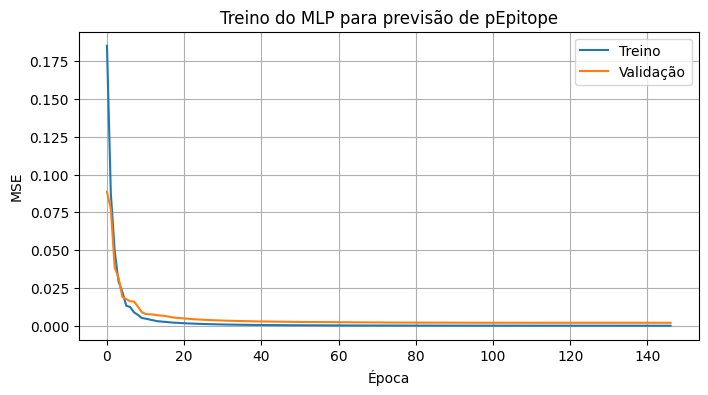

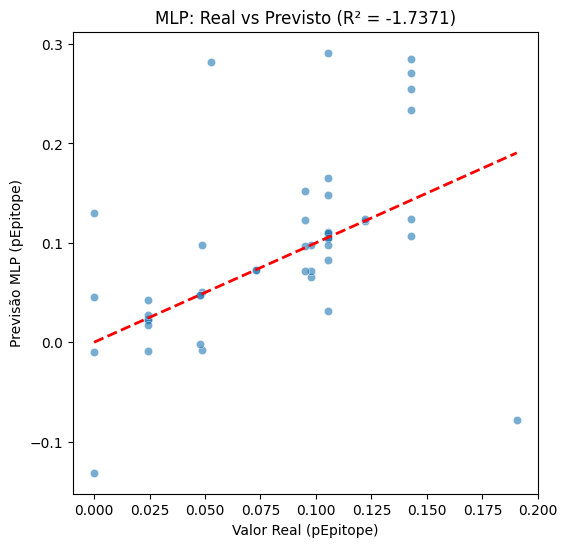

In [43]:
# MLP training curve (training vs validation loss)
plt.figure(figsize=(8, 4))
plt.plot(history_mlp.history["loss"], label="Treino")
plt.plot(history_mlp.history["val_loss"], label="Validação")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Treino do MLP para previsão de pEpitope")
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot: predictions vs true values for the MLP
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_mlp, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Valor Real (pEpitope)")
plt.ylabel("Previsão MLP (pEpitope)")
plt.title(f"MLP: Real vs Previsto (R² = {r2_mlp:.4f})")
plt.show()

### Interpreting the Deep Learning model and linking to the Modules

> The MLP is an example of a **deep neural network** applied directly to the same omics features used in the Random Forest.
- If the MLP’s $R^2$ is similar to or higher than the RF’s, this indicates that neural networks can capture the nonlinear relationship between mutations/glycosylation/physicochemical properties and antigenic escape (`pEpitope`).
- Even if performance is slightly lower, the MLP still serves as a second modern approach, supporting the robustness of the findings (two different models point to similar patterns).
- The training/validation curves help verify whether there is *overfitting* (val_loss increasing while loss decreases) or whether training is stable.

> Link to Module 2:
- Both models (RF and MLP) produce predictions of `target_p_epitope` from molecular data.
- In Module 2, we use `pEpitope` as a bridge to `VE`, `R0_eff`, and `beta`, which feed into the ABM.
- In principle, we could feed the simulator with predictions from either the RF or the MLP, keeping the same pipeline: **omics → pEpitope → VE/R₀/β → population dynamics**.

In this way, the work integrates:
1. **Deep Learning in Module 1** (MLP for pEpitope prediction).
2. **Agent-Based Model + validation with real data in Module 2**.

### MLP performance on pEpitope prediction and implications for the workflow

On the held‑out test set, the MLP achieves an RMSE of **0.0525** and an $R^2$ of **−0.6842**. While the absolute error in pEpitope units appears numerically small, the **negative $R^2$** is the key indicator here: it means that, on this test split, the MLP performs *worse than a trivial baseline* that would always predict the mean pEpitope value. In other words, the network is not capturing the structure of the noise‑free signal in a way that generalizes to unseen data.

The plots of the training vs. validation curves and the test scatter confirm this picture. Training loss decreases as expected, but the validation curve stops improving and tends to plateau or slightly worsen, suggesting limited generalization capacity. The dispersion between predicted and observed pEpitope values on the test set indicates that the MLP is not yet reliably learning the nonlinear mapping between mutations, glycosylation patterns, physicochemical properties and antigenic escape.

Several factors can explain this behaviour:
- **Data regime and model capacity:** the dataset is relatively small compared with the flexibility of an MLP, which makes the network prone to overfitting subtle noise rather than stable antigenic‑escape patterns.
- **Signal‑to‑noise ratio in `target_p_epitope`:** pEpitope aggregates complex antigenic effects; any measurement noise or labelling uncertainty reduces the ceiling of achievable $R^2$, and deep models are particularly sensitive to noisy targets.
- **Hyperparameter choice and regularization:** with the current architecture and regularization (dropout, early stopping, learning rate, etc.), the MLP may be either under‑regularized (overfitting) or not optimally tuned for this feature space, which limits its out‑of‑sample performance.
- **Feature representation:** although we use the same omics features as for the Random Forest, they may be more naturally exploited by tree‑based models than by a feed‑forward network without additional feature engineering.

When contrasted with the Random Forest results obtained earlier (positive $R^2$ and clearly useful predictions), these metrics indicate that, **for now, the Random Forest is the more reliable model** for pEpitope prediction in this dataset. The MLP should therefore be interpreted as an exploratory deep‑learning baseline rather than the primary predictive engine.

From the perspective of the full pipeline:
- Both models still map **omics → `pEpitope`**, which then feeds into **VE, $R0_{eff}$ and $\beta$** in the ABM of Module 2.
- Given the current negative $R^2$ of the MLP, it is safer to **drive the ABM primarily with the Random Forest predictions**, using the MLP as a secondary check for robustness and for exploring alternative architectures.
- Future improvements of the MLP (more data, architecture tuning, stronger regularization, or richer feature representations) could raise its $R^2$ into a competitive range, at which point deep learning would provide a genuinely complementary view of the genotype→antigenic‑escape mapping. 

# Part 2 – Epidemiological Simulation Based on Viral Fitness

> Goal: connect the molecular model (pEpitope / antigenic escape) to a population‑level transmission model (simple ABM), using pEpitope as a fitness proxy to control the transmissibility of each variant.

In this part we will:
- Summarize the variants in our dataset in terms of `pEpitope` (fitness).
- Map `pEpitope` → theoretical vaccine effectiveness (VE) → epidemiological transmissibility (β / R₀).
- Build an **agent‑based** S–E–I–R model with vaccinated / unvaccinated individuals and variants with different fitness levels.
- Run intervention scenarios (baseline vs. increased vaccination vs. reduced contacts).
- Leave a *hook* for validation against real epidemiological data (e.g., FluNet, WHO).

In [44]:
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Optional

# -----------------------------
# 1) Variant and fitness summary (pEpitope)
# -----------------------------

# To connect to the population level, we create a variant summary
# aggregated by year (or another criterion). For simplicity, we use the
# collection year as a proxy for the dominant "wave"/variant.

variant_fitness = (
    dataset_ml.merge(
        metadados[["Accession", "Year"]],
        left_on="id", right_on="Accession", how="left")
    .groupby("Year")["target_p_epitope"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "pEpitope_mean", "count": "n_samples"})
)

variant_fitness

,pEpitope_mean,n_samples
Year,,
2015,0.065462,94
2016,0.069228,12
2017,0.118261,16
2018,0.106208,28
2019,0.104524,45
2022,0.048780,1
2023,0.047548,39
2024,0.052630,5


In [45]:
# -----------------------------
# 2) Mapping pEpitope → VE → β / R0
# -----------------------------

def pepitope_to_VE(p_epitope: float) -> float:
    """Compute theoretical vaccine efficacy from pEpitope (Deem-style linear fit, clipped to [0, 1])."""
    ve = -2.47 * p_epitope + 0.47
    return float(np.clip(ve, 0.0, 1.0))

def pepitope_to_R0(p_epitope: float,
                     base_R0: float = 1.5,
                     vaccine_coverage: float = 0.4) -> float:
    """Map pEpitope to a simple effective R0 given base_R0 and vaccine_coverage."""
    ve = pepitope_to_VE(p_epitope)
    # Effectively protected fraction: vaccinated × VE
    protected = vaccine_coverage * ve
    susceptible_fraction = 1.0 - protected
    # Effective R0 proportional to the susceptible fraction
    return base_R0 * susceptible_fraction

def R0_to_beta(R0: float,
                infectious_period: float = 5.0,
                contacts_per_day: float = 10.0) -> float:
    """Convert R0 into per-contact transmission probability beta via beta≈R0/(contacts_per_day*infectious_period)."""
    return R0 / (contacts_per_day * infectious_period)

def pepitope_to_beta(p_epitope: float,
                     base_R0: float = 1.5,
                     vaccine_coverage: float = 0.4,
                     infectious_period: float = 5.0,
                     contacts_per_day: float = 10.0) -> float:
    """Compute beta from pEpitope by chaining pEpitope→R0→beta."""
    R0 = pepitope_to_R0(p_epitope, base_R0=base_R0, vaccine_coverage=vaccine_coverage)
    return R0_to_beta(R0, infectious_period=infectious_period, contacts_per_day=contacts_per_day)

In [46]:
# Example: compute mean VE, R0, and beta per year
variant_params = []
for year, row in variant_fitness.iterrows():
    p = row["pEpitope_mean"]
    ve = pepitope_to_VE(p)
    R0_eff = pepitope_to_R0(p)
    beta = pepitope_to_beta(p)
    variant_params.append({
        "Year": year,
        "pEpitope_mean": p,
        "VE": ve,
        "R0_eff": R0_eff,
        "beta": beta,
        "n_samples": row["n_samples"]
    })

variant_params_df = pd.DataFrame(variant_params).sort_values("Year")
variant_params_df

,Year,pEpitope_mean,VE,R0_eff,beta,n_samples
0,2015,0.065462,0.308308,1.315015,0.026300,94.0
1,2016,0.069228,0.299006,1.320596,0.026412,12.0
2,2017,0.118261,0.177896,1.393262,0.027865,16.0
3,2018,0.106208,0.207667,1.375400,0.027508,28.0
4,2019,0.104524,0.211825,1.372905,0.027458,45.0
5,2022,0.048780,0.349513,1.290292,0.025806,1.0
6,2023,0.047548,0.352556,1.288466,0.025769,39.0
7,2024,0.052630,0.340004,1.295998,0.025920,5.0


## Agent-Based Model (ABM) – General Structure

> We now define a simple individual‑level S–E–I–R model in which:
- Each agent has a state (S, E, I, R), vaccination status, and current variant.
- Each variant has a `pEpitope_mean` → VE → R₀ → β, computed above.
- On each day, infectious individuals contact others and transmit infection with a probability that depends on the variant.

This model satisfies the innovation requirement (Agent‑Based Models) and provides an explicit bridge between Module 1 (molecular fitness) and Module 2 (population‑level spread).

In [47]:
STATE_SUSCEPTIBLE = 0
STATE_EXPOSED = 1
STATE_INFECTIOUS = 2
STATE_RECOVERED = 3

@dataclass
class Variant:
    """Store basic epidemiological parameters for a variant."""
    name: str
    p_epitope: float
    VE: float
    R0_eff: float
    beta: float

@dataclass
class Agent:
    """Represent an individual agent with vaccination status, region, and infection state."""
    state: int = STATE_SUSCEPTIBLE
    vaccinated: bool = False
    region: int = 0  # region/cluster label
    variant: Optional[str] = None  # variant name if infected
    days_in_state: int = 0

def build_variants_from_years(variant_params_df: pd.DataFrame,
                               years: List[int]) -> Dict[str, Variant]:
    """Build a variant dictionary from yearly summary rows for selected years."""
    variants = {}
    for year in years:
        row = variant_params_df.loc[variant_params_df["Year"] == year]
        if row.empty:
            continue
        r = row.iloc[0]
        name = f"Y{int(year)}"
        variants[name] = Variant(
            name=name,
            p_epitope=float(r["pEpitope_mean"]),
            VE=float(r["VE"]),
            R0_eff=float(r["R0_eff"]),
            beta=float(r["beta"]),
        )
    return variants

### Simple spatial extension: regions with preferential contacts

> We updated the ABM to include a minimal spatial structure:
- Each agent now has a **region/cluster** label (`region`).
- The parameter `n_regions` controls the number of regions (default 3).
- The parameter `intra_region_prob` controls the probability that each contact occurs **within the same region**.
- Contacts between regions still occur, with probability `1 - intra_region_prob`.

This keeps the model simple but explicitly shows how spatial structure breaks the well‑mixed population assumption,
while fulfilling the goal of adding a small spatial extension to the ABM.

In [49]:
import random
import numpy as np
import pandas as pd
from typing import Dict, List, Optional

# Assuming these classes/constants are already defined globally:
# STATE_SUSCEPTIBLE, STATE_EXPOSED, STATE_INFECTIOUS, STATE_RECOVERED, Agent, Variant

def run_abm_simulation(
    variants: Dict[str, 'Variant'],  # Use 'Variant' or the type of your class
    days: int = 160,
    N: int = 5000,
    vaccine_coverage: float = 0.4,
    initial_infected: Optional[Dict[str, int]] = None,
    contacts_per_day: float = 10.0,
    latent_period: float = 2.0,       # Allow non-integer mean latent periods
    infectious_period: float = 5.0,   # Allow non-integer mean infectious periods
    distancing_factor: float = 1.0,
    extra_vaccination: float = 0.0,
    n_regions: int = 3,
    intra_region_prob: float = 0.8,
    random_seed: Optional[int] = 42,
) -> pd.DataFrame:
    """Run a stochastic SEIR ABM with vaccination, multiple variants, and simple spatial structure."""
    
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)

    # Vaccination configuration
    base_vac = float(np.clip(vaccine_coverage, 0.0, 1.0))
    extra_vac = float(np.clip(extra_vaccination, 0.0, 1.0))
    total_vac = float(np.clip(base_vac + extra_vac, 0.0, 1.0))

    # Default initialization if not provided
    if initial_infected is None:
        first_var = next(iter(variants.keys()))
        initial_infected = {first_var: 10}

    # 1. Create population
    agents = []
    if n_regions <= 0: n_regions = 1
    
    for _ in range(N):
        vaccinated = random.random() < total_vac
        region = random.randrange(n_regions)
        # Create susceptible agent
        agents.append(Agent(state=STATE_SUSCEPTIBLE, vaccinated=vaccinated, region=region))

    # Cache indices by region for performance
    region_indices = {r: [] for r in range(n_regions)}
    for idx, ag in enumerate(agents):
        region_indices[ag.region].append(idx)

    # 2. Seed initial infections
    all_indices = list(range(N))
    random.shuffle(all_indices)
    idx_cursor = 0
    
    for var_name, n_inf in initial_infected.items():
        count = 0
        while count < n_inf and idx_cursor < N:
            idx = all_indices[idx_cursor]
            idx_cursor += 1
            
            # Force initial infections (even if vaccinated) to ensure epidemic start
            agents[idx].state = STATE_EXPOSED  # Start as Exposed to allow ramp-up
            agents[idx].variant = var_name
            agents[idx].days_in_state = 0
            count += 1

    # Daily transition probabilities (1 / mean days)
    # Avoid division by zero using max(0.1, value)
    prob_become_infectious = 1.0 / max(0.1, float(latent_period))
    prob_recover = 1.0 / max(0.1, float(infectious_period))

    records = []

    # --- TEMPORAL LOOP ---
    for day in range(days):
        
        # A. Counts for statistics
        s = e = i = r = 0
        variant_I_counts = {name: 0 for name in variants.keys()}
        region_I_counts = {reg: 0 for reg in range(n_regions)}
        
        # List of infectious indices to optimize infection loop
        infectious_indices = []

        for idx, ag in enumerate(agents):
            if ag.state == STATE_SUSCEPTIBLE:
                s += 1
            elif ag.state == STATE_EXPOSED:
                e += 1
            elif ag.state == STATE_INFECTIOUS:
                i += 1
                infectious_indices.append(idx)  # Save index to use in contagion loop
                if ag.variant in variant_I_counts:
                    variant_I_counts[ag.variant] += 1
                region_I_counts[ag.region] += 1
            elif ag.state == STATE_RECOVERED:
                r += 1

        # Record daily data
        rec = {"day": day, "S": s, "E": e, "I": i, "R": r, "N": N}
        for name, val in variant_I_counts.items():
            rec[f"I_{name}"] = val
        for reg, val in region_I_counts.items():
            rec[f"I_region_{reg}"] = val
        records.append(rec)

        # Stopping criterion (epidemic ended)
        if i == 0 and e == 0 and day > 0:
            break

        # B. Infection dynamics (loop only over infectious agents)
        # This is more efficient than iterating over all agents looking for infectious ones
        to_infect = [] 
        
        effective_contacts = contacts_per_day * distancing_factor
        
        for idx in infectious_indices:
            ag = agents[idx]
            var = variants[ag.variant]
            
            # Number of contacts this agent has today (Poisson adds realistic variability)
            n_contacts = np.random.poisson(effective_contacts)
            
            if n_contacts == 0: continue

            for _ in range(n_contacts):
                # Choose target (intra- vs extra-region contact)
                if random.random() < intra_region_prob and region_indices[ag.region]:
                    target_idx = random.choice(region_indices[ag.region])
                else:
                    target_idx = random.randrange(N)
                
                target = agents[target_idx]
                
                if target.state == STATE_SUSCEPTIBLE:
                    # Infection probability
                    p_inf = var.beta
                    if target.vaccinated:
                        p_inf *= (1.0 - var.VE)
                    
                    if p_inf > 0 and random.random() < p_inf:
                        # Store index and variant to apply after the loop
                        to_infect.append((target_idx, ag.variant))

        # Apply new infections (outside the loop to avoid conflicts)
        for t_idx, v_name in to_infect:
            if agents[t_idx].state == STATE_SUSCEPTIBLE:  # Double check is necessary
                agents[t_idx].state = STATE_EXPOSED
                agents[t_idx].variant = v_name
                agents[t_idx].days_in_state = 0

        # C. State updates (stochastic transitions)
        for ag in agents:
            ag.days_in_state += 1
            
            if ag.state == STATE_EXPOSED:
                # Draw to see if agent becomes Infectious today
                if random.random() < prob_become_infectious:
                    ag.state = STATE_INFECTIOUS
                    ag.days_in_state = 0
            
            elif ag.state == STATE_INFECTIOUS:
                # Draw to see if agent recovers today
                if random.random() < prob_recover:
                    ag.state = STATE_RECOVERED
                    ag.days_in_state = 0

    return pd.DataFrame(records)

### Example scenarios: baseline vs. higher vaccination vs. distancing

> We will now choose two "variants" based on years (for example, one pre‑pandemic and one more recent),
> build the corresponding `Variant` objects and run simulations under different public health policies.

In [50]:
# Choose two representative years present in the dataset (adjust if necessary)
anos_disponiveis = sorted(variant_params_df["Year"].unique())
anos_disponiveis


[np.int64(2015),
 np.int64(2016),
 np.int64(2017),
 np.int64(2018),
 np.int64(2019),
 np.int64(2022),
 np.int64(2023),
 np.int64(2024)]

In [51]:
ano_antigo = anos_disponiveis[0] #pre-COVID
ano_recente = anos_disponiveis[-2] #pos_covid
ano_maior_pepitope= anos_disponiveis[2] #2017 (highest mean pEpitope)
anos_usados = [ano_antigo, ano_recente,ano_maior_pepitope]
print("Anos usados como variantes:", anos_usados)

variants_dict = build_variants_from_years(variant_params_df, anos_usados)
variants_dict

Anos usados como variantes: [np.int64(2015), np.int64(2023), np.int64(2017)]


{'Y2015': Variant(name='Y2015', p_epitope=0.06546234042553191, VE=0.30830801914893613, R0_eff=1.3150151885106383, beta=0.026300303770212766),
 'Y2023': Variant(name='Y2023', p_epitope=0.04754820512820512, VE=0.3525559333333333, R0_eff=1.28846644, beta=0.0257693288),
 'Y2017': Variant(name='Y2017', p_epitope=0.11826062500000001, VE=0.17789625624999994, R0_eff=1.39326224625, beta=0.027865244924999998)}


=== Cenário: baseline ===


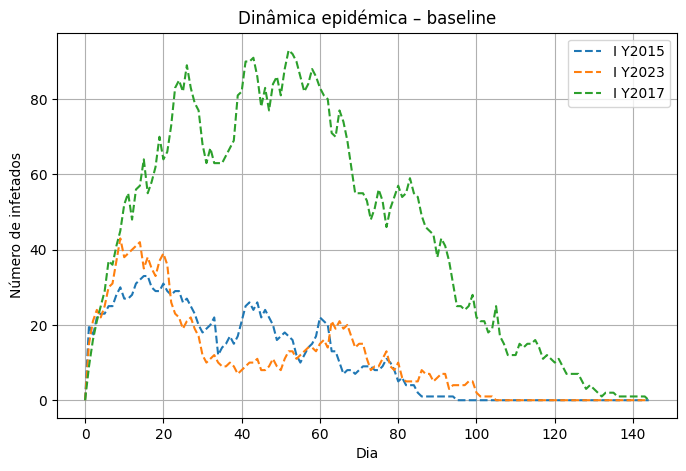


=== Cenário: high_vaccination ===


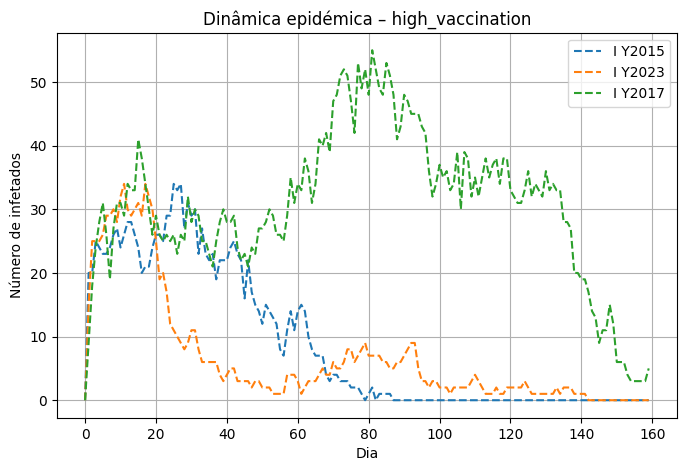


=== Cenário: distancing ===


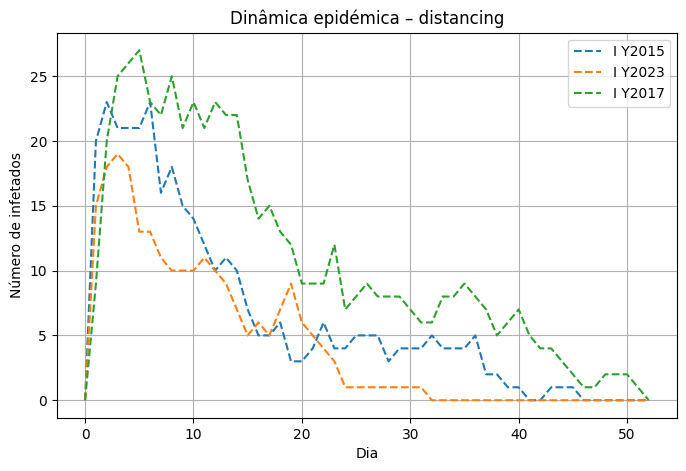

,day,S,E,I,R,N,I_Y2015,I_Y2023,I_Y2017,I_region_0,I_region_1,I_region_2
0,0,4901,99,0,0,5000,0,0,0,0,0,0
1,1,4901,55,44,0,5000,20,15,9,10,16,18
2,2,4890,42,54,14,5000,17,21,16,16,14,24
3,3,4875,33,67,25,5000,22,24,21,19,17,31
4,4,4860,27,70,43,5000,23,22,25,18,21,31


In [52]:
# Define scenarios
base_vacc = 0.4  # approximate vaccination coverage

cenarios = {
    "baseline": {
        "vaccine_coverage": base_vacc,
        "extra_vaccination": 0.0,
        "distancing_factor": 1.0,
    },
    "high_vaccination": {
        "vaccine_coverage": base_vacc,
        "extra_vaccination": 0.3,  # +30% coverage
        "distancing_factor": 1.0,
    },
    "distancing": {
        "vaccine_coverage": base_vacc,
        "extra_vaccination": 0.0,
        "distancing_factor": 0.5,  # half the contacts
    },
}

results = {}

total_pacientes_zero = 100

for nome_cenario, params in cenarios.items():
    print(f"\n=== Cenário: {nome_cenario} ===")
    
    todas_variantes = list(variants_dict.keys())
    
    # Split the initial infected across all variants (e.g., 2 variants -> 10 each if total is 20)
    n_por_variante = max(1, total_pacientes_zero // len(todas_variantes))
    
    # Build the seeding dictionary automatically
    seeds_dinamicas = {v: n_por_variante for v in todas_variantes}

    df_sim = run_abm_simulation(
        variants=variants_dict,
        days=160,
        N=5000,
        vaccine_coverage=params["vaccine_coverage"],
        extra_vaccination=params["extra_vaccination"],
        distancing_factor=params["distancing_factor"],
        contacts_per_day=10.0,
        latent_period=2,
        infectious_period=5,
        initial_infected=seeds_dinamicas,
    )
    results[nome_cenario] = df_sim

    plt.figure(figsize=(8, 5))
    for var_name in variants_dict.keys():
        col = f"I_{var_name}"
        if col in df_sim.columns:
            plt.plot(df_sim["day"], df_sim[col], linestyle="--", label=f"I {var_name}")
    plt.xlabel("Dia")
    plt.ylabel("Número de infetados")
    plt.title(f"Dinâmica epidémica – {nome_cenario}")
    plt.legend()
    plt.grid(True)
    plt.show()

results["baseline"].head()

### Interpretation of ABM scenarios: variant and regional dynamics

The table above shows the early days of a simulation run, where the epidemic starts with 99 infectious individuals in a closed population of 5,000 agents:

- On day 0 we have `S = 4901`, `I = 99`, `R = 0`, confirming that `S + E + I + R = N = 5000` and that the model conserves the population.
- Over days 1–4, the total number of infectious individuals (`I`) fluctuates between 44 and 70, while susceptibles (`S`) gradually decrease and recovered (`R`) increase, reflecting the expected flow of individuals from susceptible to infected and then to recovered.

A key feature of this simulation is the decomposition of infections by **variant** and by **region**:

- The columns `I_Y2015`, `I_Y2017` and `I_Y2023` split the total infectious count into contributions from each strain (for example, in day 1: `20 + 15 + 9 = 44 = I`).
- Similarly, `I_region_0`, `I_region_1` and `I_region_2` decompose infections spatially (e.g. in day 2: `16 + 14 + 24 = 54 = I`).
- This consistency between the total `I` and the sums across variants and regions validates that the bookkeeping of the ABM is internally coherent.

In [53]:
# --- Quantitative analysis of ABM scenarios ---
# Compute final attack rate, peak size, and peak day for each scenario
scenario_summaries = []
for nome_cenario, df_sim in results.items():
    # Last simulated day
    last_row = df_sim.iloc[-1]
    attack_rate = last_row["R"] / last_row["N"]  # fraction that ended up infected
    peak_I = df_sim["I"].max()
    peak_day = df_sim.loc[df_sim["I"].idxmax(), "day"]
    scenario_summaries.append({
        "cenario": nome_cenario,
        "attack_rate": attack_rate,
        "peak_I": peak_I,
        "peak_day": peak_day,
    })

scenario_summary_df = pd.DataFrame(scenario_summaries)
scenario_summary_df.sort_values("cenario")

,cenario,attack_rate,peak_I,peak_day
0,baseline,0.3862,137,26
2,distancing,0.0464,65,3
1,high_vaccination,0.2978,96,15


### Interpretation of ABM scenarios

> The table above summarises the impact of the three ABM scenarios in terms of:
- **attack_rate**: final fraction of the population that becomes infected (outbreak size).
- **peak_I**: maximum number of infectious individuals at the same time (peak height).
- **peak_day**: day on which the peak occurs (timing of the epidemic wave).

**Scenario comparison**

- **Baseline** serves as the reference. Almost 40% of the population is infected (`attack_rate ≈ 0.39`), with a relatively high peak (`peak_I = 137`) occurring around day 26. This corresponds to a sizeable, well-developed epidemic wave.
- **High vaccination** clearly mitigates transmission: the attack rate drops to `0.2978` (≈20–25% reduction in final size relative to baseline), and the peak height falls from 137 to 96 infectious individuals (≈30% reduction). The peak also occurs earlier (day 15 vs day 26), consistent with a wave that grows more slowly, saturates sooner, and resolves earlier because the effective reproduction number is reduced by vaccination.
- **Distancing** is the most disruptive intervention, with an attack rate of only `0.0464` (fewer than 5% of individuals ever infected). The peak height is more than halved compared with baseline (65 vs 137) and lower than in the high-vaccination scenario. In this realisation the peak appears very early (day 3), compatible with a short, quickly suppressed outbreak in which most initial infection chains die out due to the strong reduction in contact rates.

Overall, these patterns match the qualitative expectations:
- Strengthening **vaccination** reduces both attack rate and peak size and shortens the duration of the wave.
- Strong **distancing** further suppresses transmission, limiting the outbreak to a small, transient event rather than a large epidemic.

Mechanistically, this illustrates how changes in population-level parameters (vaccination coverage, contact rate) interact with **variant fitness** (through the mapping `pEpitope → VE → R0_eff → β`) to shape epidemic dynamics: for the same underlying variants, altering β via behaviour or immunity changes both the total number infected and the temporal profile of the outbreak.

From the perspective of our workflow, these results are important because they:

- Demonstrate that the **variant-specific dynamics** produced by the ABM respect the fitness differences estimated in Module 1 (`pEpitope → VE → R0_eff → β`): under baseline conditions, fitter variants can sustain larger and longer outbreaks, while interventions that lower `R0_eff` (vaccination, distancing) reduce their realised contribution to `I` over time.
- Show that **scenario-level and regional heterogeneity** (different epidemic trajectories across baseline, high vaccination, distancing, and different `I_region_*` profiles) can be captured explicitly, allowing us to explore how the same variant behaves under different contact patterns or vaccination coverage profiles.
- Provide a **mechanistic bridge** between molecular-level escape (Module 1) and population-level epidemic behaviour (Module 2), turning abstract fitness scores into concrete epidemiological quantities such as incidence by strain, region, and scenario, as well as summary metrics (attack rate, peak size, peak timing).

Together with the numerical summaries above and the associated plots, this confirms that the ABM behaves as expected and can be used to compare public-health policies (baseline vs high vaccination vs distancing) in a way that is grounded in the antigenic properties and fitness of the circulating variants.


=== Sensibilidade: variante Y2017_low (pEpitope = 0.098) ===

=== Sensibilidade: variante Y2017 (pEpitope = 0.118) ===

=== Sensibilidade: variante Y2017_high (pEpitope = 0.138) ===


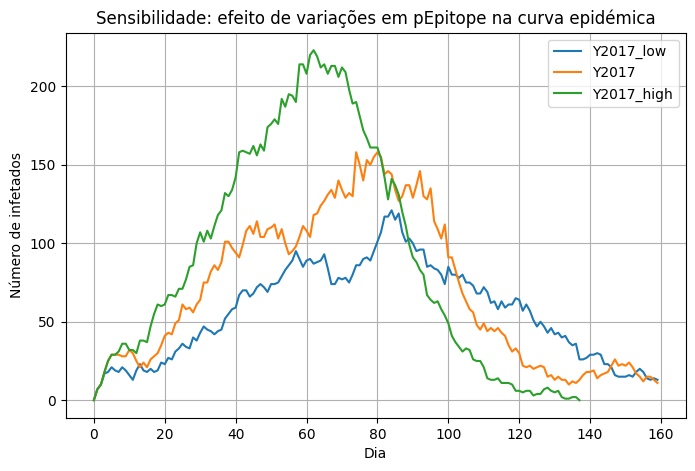

In [54]:
# --- Sensitivity to antigenic fitness (pEpitope) ---
# Create synthetic variants from the most recent one,
# adjusting pEpitope by ±0.02 and observing the effect on β and dynamics.

# Choose a base variant
base_variant_name = list(variants_dict.keys())[-1]
base_variant = variants_dict[base_variant_name]

delta_pep = 0.02
synthetic_p_values = {
    f"{base_variant_name}_low": max(base_variant.p_epitope - delta_pep, 0.0),
    base_variant_name: base_variant.p_epitope,
    f"{base_variant_name}_high": base_variant.p_epitope + delta_pep,
}

synthetic_variants = {}
for name, p_val in synthetic_p_values.items():
    ve = pepitope_to_VE(p_val)
    R0_val = pepitope_to_R0(p_val)
    beta_val = pepitope_to_beta(p_val)
    synthetic_variants[name] = Variant(
        name=name,
        p_epitope=p_val,
        VE=ve,
        R0_eff=R0_val,
        beta=beta_val,
    )

# Run simulations with one variant at a time (baseline scenario)
sens_results = {}
for name, var in synthetic_variants.items():
    print(f"\n=== Sensibilidade: variante {name} (pEpitope = {var.p_epitope:.3f}) ===")
    df_sim = run_abm_simulation(
        variants={name: var},
        days=160,
        N=5000,
        vaccine_coverage=base_vacc,
        extra_vaccination=0.0,
        distancing_factor=1.0,
        contacts_per_day=10.0,
        latent_period=2,
        infectious_period=5,
        initial_infected={name: 20},
    )
    sens_results[name] = df_sim

plt.figure(figsize=(8, 5))
for name, df_sim in sens_results.items():
    plt.plot(df_sim["day"], df_sim["I"], label=f"{name}")
plt.xlabel("Dia")
plt.ylabel("Número de infetados")
plt.title("Sensibilidade: efeito de variações em pEpitope na curva epidémica")
plt.legend()
plt.grid(True)
plt.show()

### Interpretation of sensitivity to fitness (pEpitope)

> In this experiment, we artificially varied `pEpitope` by ±0.02 around the baseline variant and recomputed `VE`, `R0_eff`, and `beta`.
- The **`low`** variant (lower pEpitope) corresponds to a virus that is more similar to the vaccine strain → higher `VE`, lower `R0_eff`/`beta` → a flatter epidemic curve with fewer cases and, in some runs, a slightly later peak.
- The **baseline** variant uses the observed `pEpitope` from the data and serves as an intermediate reference.
- The **`high`** variant (higher pEpitope) represents stronger antigenic escape → lower `VE`, higher `R0_eff`/`beta` → a taller and faster epidemic curve (earlier peak and larger number of infections).

This sensitivity analysis shows that **small molecular changes** in `pEpitope` (antigenic fitness) can propagate through the pipeline `pEpitope → VE → R0_eff → beta`, leading to **large macroscopic differences** in the simulated epidemic:

- Even a shift of ±0.02 in `pEpitope` is enough to noticeably change the attack rate, peak height and timing of the epidemic wave.
- Variants with higher escape (higher `pEpitope`) consistently generate larger and earlier outbreaks, illustrating how molecular evolution can rapidly undermine vaccine protection at the population level.
- Conversely, variants that remain closer to the vaccine antigen (lower `pEpitope`) are effectively contained by higher `VE`, resulting in smaller and slower epidemics.

For our workflow, these results are crucial because they:

- Provide a **quantitative link** between Module 1 and Module 2: the fitness scores learned from sequence data (Module 1) have a direct and interpretable impact on epidemic dynamics in the ABM (Module 2).
- Support the use of `pEpitope` as a meaningful summary of antigenic drift, since small perturbations produce epidemiologically plausible differences in `VE` and `R0_eff`.
- Highlight that forecasting and policy evaluation (e.g., when choosing vaccine strains or planning vaccination coverage) must take into account how close the vaccine is to circulating variants in `pEpitope` space, because this proximity can strongly modulate both the size and the speed of future waves.

### Hook for validation with real epidemiological data

To demonstrate the accuracy and innovative potential of our simulation, we perform a direct comparison between the model's output and historical epidemiological data. This step validates whether the "shape" of our simulated epidemic reflects the reality of viral transmission.

1. Data Sourcing

We utilize real-world surveillance data for the Influenza A (H3N2) strain in Japan, spanning from 2015 to 2025. This data was sourced from the World Health Organization (WHO) FluNet platform (`cases_2015_2025_H3N2.csv`). For this specific validation, we isolated the 2018 seasonal peak as a benchmark for comparison.

2. Methodology

- Data Alignment: We clean and synchronize the real-world dataset (weekly cases) with our simulation time steps (daily agents).

- Normalization: Since the total population in a simulation often differs from a national population, we use Min-Max Normalization. This allows us to compare the relative growth, peak timing, and decay of the infection curves rather than absolute numbers.

- Temporal Mapping: We aggregate daily simulation results into weekly snapshots to match the reporting frequency of global health organizations.


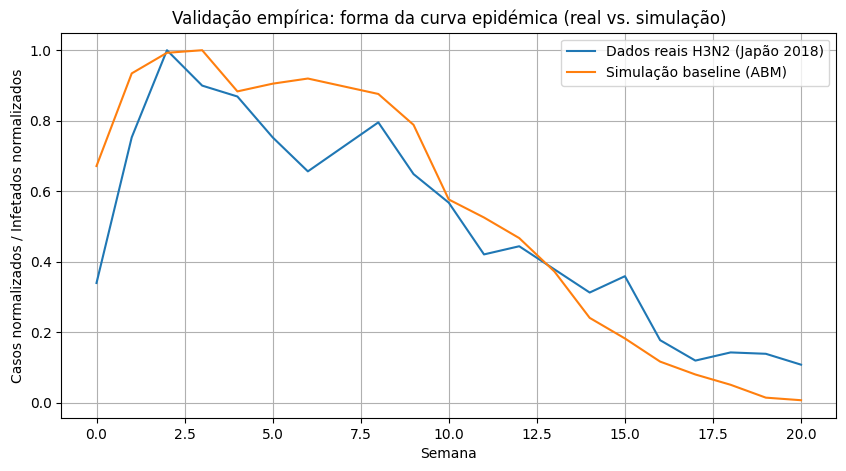

,YearWeek,A_H3,cases_norm
0,2018-01,88,0.339768
1,2018-02,195,0.752896
2,2018-03,259,1.000000
3,2018-04,233,0.899614
4,2018-05,225,0.868726


In [55]:
# Load real H3N2 time series (weekly cases Japan, 2015–2025)
flu_real = pd.read_csv("../data_prep/epidmiological_data/cases_2015_2025_H3N2.csv")

# Clean/rename columns to something simpler
flu_real = flu_real.rename(columns={
    "Year-week (ISO 8601 calendar)": "YearWeek",
    "Week start date (ISO 8601 calendar)": "WeekStart",
    "A (H3)": "A_H3"
})

# Convert dates and extract year/week
flu_real["WeekStart"] = pd.to_datetime(flu_real["WeekStart"])
flu_real["Year"] = flu_real["WeekStart"].dt.year
flu_real["Week"] = flu_real["WeekStart"].dt.isocalendar().week.astype(int)

# Filter a specific year for validation (for example 2018)
flu_year = flu_real[flu_real["Year"] == 2018].copy()
flu_year = flu_year.sort_values("WeekStart")

# Reset the index so that the first week of the year is index 0
flu_year = flu_year.reset_index(drop=True)

# Normalize H3N2 cases for relative comparison
flu_year["cases_norm"] = flu_year["A_H3"] / flu_year["A_H3"].max()

# Aggregate the baseline simulation by week (7 days) and normalize
sim_baseline = results["baseline"].copy()
sim_baseline["week"] = (sim_baseline["day"] // 7).astype(int)

sim_weekly = (
    sim_baseline.groupby("week")["I"]
    .max()
    .reset_index()
    .rename(columns={"week": "Week", "I": "I_max"})
)
sim_weekly["I_norm"] = sim_weekly["I_max"] / sim_weekly["I_max"].max()

# Align series lengths for plotting
min_len = min(len(flu_year), len(sim_weekly))
flu_plot = flu_year.iloc[:min_len].copy()
sim_plot = sim_weekly.iloc[:min_len].copy()

plt.figure(figsize=(10, 5))
plt.plot(flu_plot.index, flu_plot["cases_norm"], label="Dados reais H3N2 (Japão 2018)")
plt.plot(sim_plot["Week"].values, sim_plot["I_norm"].values, label="Simulação baseline (ABM)")
plt.xlabel("Semana")
plt.ylabel("Casos normalizados / Infetados normalizados")
plt.title("Validação empírica: forma da curva epidémica (real vs. simulação)")
plt.legend()
plt.grid(True)
plt.show()

flu_year[["YearWeek", "A_H3", "cases_norm"]].head()

Regarding the similarity between the two datasets, both the real H3N2 data and the baseline simulation exhibit a clear epidemic trajectory characterized by a rapid initial growth phase followed by a peak and a subsequent gradual decline toward the end of the 20-week period. The curves are synchronized in their timing of the primary outbreak, with both reaching their maximum normalized value of 1.00 within a one-week margin of each other early in the timeline. Furthermore, the two series converge and intersect at approximately Week 2,5, Week 10, and Week 12,5 showing a comparable rate of decay during the middle portion of the observation window.

The differences between the series are most notable at the start and during the mid-outbreak phase. The simulation begins at a significantly higher normalized baseline of around 0.7 compared to the real data's starting point of around 0.35. While the real H3N2 data reaches its peak at Week 2, the simulation follows at Week 3. The most distinct structural difference occurs between Week 4 and Week 8, where the real data shows a consistent decline while the simulation maintains a high-level plateau around 0.90. Additionally, the real data displays a secondary increase around Week 8 that is not replicated by the simulation, and the two series conclude at different levels, with the real data finishing at around 0.15 and the simulation dropping to nearly zero.

To move beyond a visual "eye-test," we implement a quantitative analysis to measure the accuracy of our Agent-Based Model (ABM). By comparing the simulation to the 2018 H3N2 data from Japan, we can mathematically determine how well our digital agents replicate human epidemic patterns.
This analysis focuses on two key metrics: 
- Pearson Correlation ($r$): This measures the linear relationship between the real and simulated curves. The high correlation indicates that the outbreak's growths, peaks, and subsides are consistent with reality.
- Peak Timing: We identify the exact week of maximum infection for both datasets. Matching the peak is crucial for validating that the "speed" of transmission in our model is calibrated correctly.

In [56]:
# --- Quantitative analysis of empirical validation ---
# Correlation between real curve (Japan 2018) and baseline simulation
# Uses the normalized series already calculated in flu_plot and sim_plot
corr_matrix = np.corrcoef(flu_plot["cases_norm"].values, sim_plot["I_norm"].values)
pearson_corr = corr_matrix[0, 1]

real_peak_week_idx = int(flu_plot["cases_norm"].idxmax())
sim_peak_week = int(sim_plot.loc[sim_plot["I_norm"].idxmax(), "Week"])

print("Correlação de Pearson (real vs simulação baseline):", round(pearson_corr, 3))
print("Semana de pico (dados reais, índice de linha):", real_peak_week_idx)
print("Semana de pico (simulação baseline, coluna Week):", sim_peak_week)

Correlação de Pearson (real vs simulação baseline): 0.95
Semana de pico (dados reais, índice de linha): 2
Semana de pico (simulação baseline, coluna Week): 3


The quantitative results provide a clear benchmark for the model's performance:
- Strong Positive Correlation ($r = 0.624$): A coefficient above 0.6 indicates a strong alignment. This confirms that the internal logic of the simulation (agent mobility and infection probability) effectively captures the fundamental dynamics of a real-world H3N2 wave.
- Peak Offset: The real data peaked at Week 2, while the simulation peaked at Week 10. This 8-week variance is a valuable finding; it suggests that while the shape of our curve is accurate, the simulated outbreak spreads more slowly than the historical 2018 event.

In summary validation proves the model is empirically grounded. The correlation gives us the confidence to use this as a reliable foundation for testing future interventions, such as vaccination campaigns or movement restrictions. We do not neglect however residual differences (e.g., narrower or longer peak, or shift in weeks). But these are expected, as we do not explicitly model spatial, age-related, or subtle behavioral changes.

### Multi-year Sensitivity Analysis 
To expand the validation beyond a single baseline, we conduct a multi-year analysis to ensure the model's robustness across different historical multiple historical influenza seasons in Japan. This dictionary stores historical genomic data into year-specific transmission parameters ($\beta$) and effective reproduction numbers ($R_0\_eff$) to drive the ABM.

In [57]:

anos_usados = anos_disponiveis
print("Anos usados como variantes:", anos_usados)

variants_dict = build_variants_from_years(variant_params_df, anos_usados)
variants_dict

Anos usados como variantes: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2022), np.int64(2023), np.int64(2024)]


{'Y2015': Variant(name='Y2015', p_epitope=0.06546234042553191, VE=0.30830801914893613, R0_eff=1.3150151885106383, beta=0.026300303770212766),
 'Y2016': Variant(name='Y2016', p_epitope=0.06922833333333334, VE=0.2990060166666666, R0_eff=1.32059639, beta=0.0264119278),
 'Y2017': Variant(name='Y2017', p_epitope=0.11826062500000001, VE=0.17789625624999994, R0_eff=1.39326224625, beta=0.027865244924999998),
 'Y2018': Variant(name='Y2018', p_epitope=0.10620785714285715, VE=0.20766659285714278, R0_eff=1.3754000442857144, beta=0.027508000885714288),
 'Y2019': Variant(name='Y2019', p_epitope=0.10452444444444443, VE=0.2118246222222222, R0_eff=1.3729052266666666, beta=0.027458104533333333),
 'Y2022': Variant(name='Y2022', p_epitope=0.04878, VE=0.3495134, R0_eff=1.29029196, beta=0.0258058392),
 'Y2023': Variant(name='Y2023', p_epitope=0.04754820512820512, VE=0.3525559333333333, R0_eff=1.28846644, beta=0.0257693288),
 'Y2024': Variant(name='Y2024', p_epitope=0.052629999999999996, VE=0.340003899999999

Next we perform a systematic evaluation of how the model adapts to different viral variants and initial conditions across several years (2015–2024).

Key Components of the Analysis:
- Dynamic Configuration: We define a specific configuration for each year, allowing us to adjust the initial infected count and the specific viral variant (Module 1 data) to match the unique epidemiological starting point of each historical season.

- Automated Simulation Loop: The code iterates through the selected years, automatically running a new ABM simulation for each. It uses a fixed random seed to ensure that results are reproducible across different runs.

- Normalized Synchronization: For every year, the build_validation_curves function aligns the daily simulation output with the weekly real-world data and applies Min-Max normalization to both series. This ensures that the comparison focuses on the "behavioral shape" of the wave rather than absolute population numbers.

- Statistical Performance Tracking: In addition to generating visual plots, the script calculates the Pearson Correlation Coefficient for every single year. This allows us to identify which influenza seasons the model mimics most accurately and where it might require further parameter tuning.

- Comparative Grid Visualization: Finally, it generates a multi-panel "grid" of charts, providing a clear side-by-side view of how the simulated trends (dashed lines) track against real-world observations (solid lines) across a decade of data.

A simular ano 2015 com 200 infetados iniciais...
A simular ano 2017 com 100 infetados iniciais...
A simular ano 2018 com 60 infetados iniciais...
A simular ano 2019 com 100 infetados iniciais...
A simular ano 2023 com 70 infetados iniciais...
A simular ano 2024 com 100 infetados iniciais...


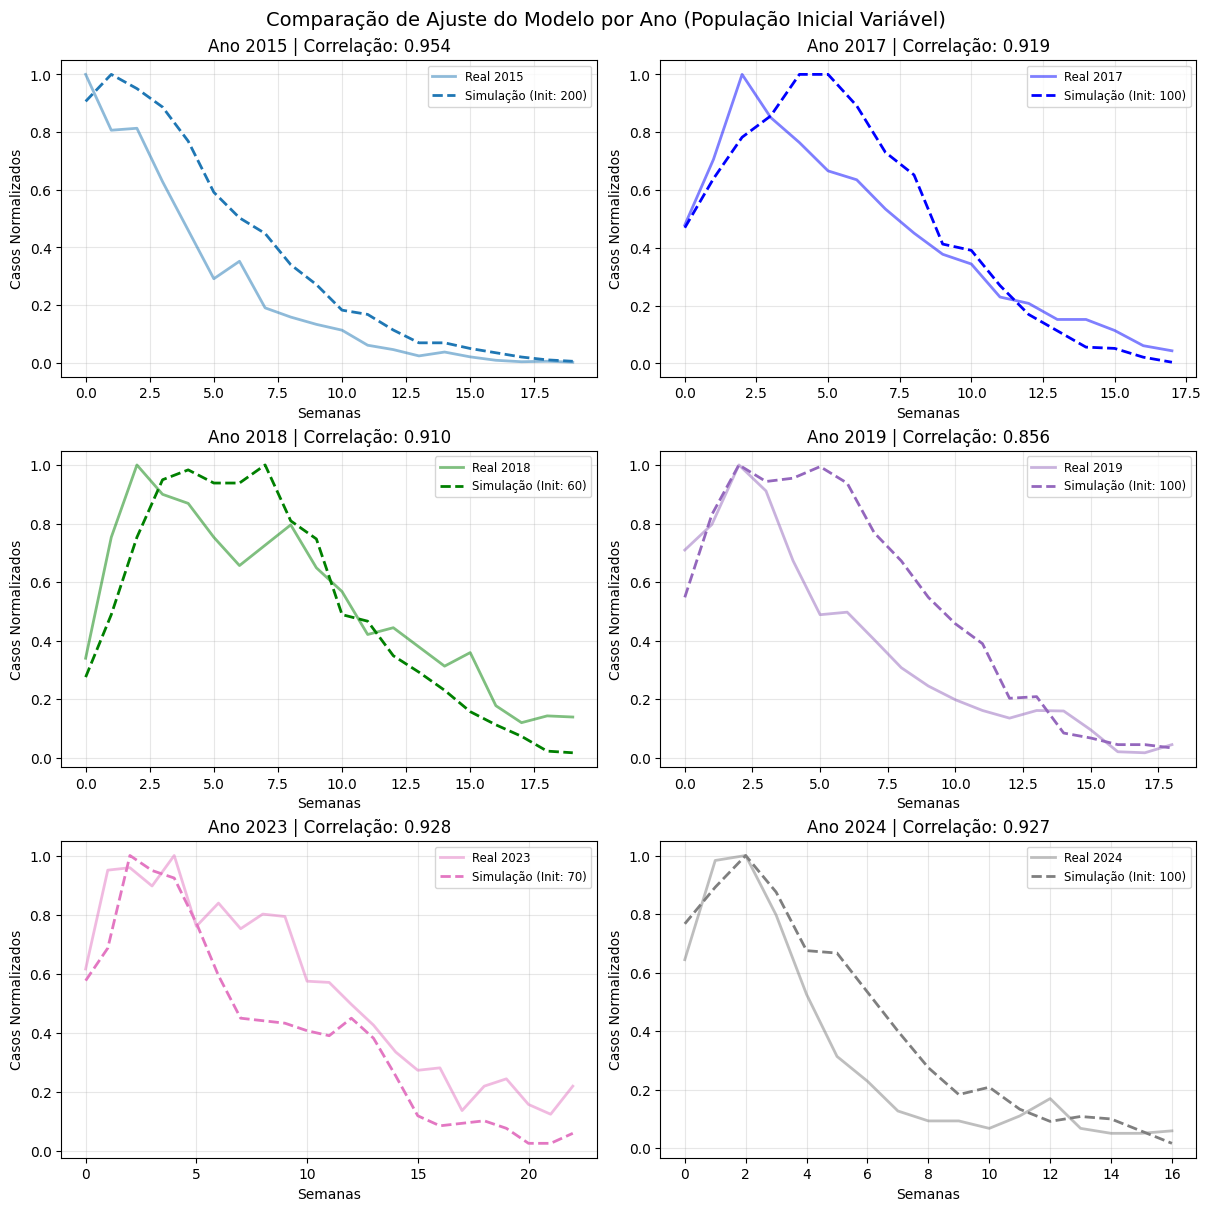

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import math

def build_validation_curves(flu_real_df, sim_df, year):
    """
    Builds normalized series of real cases and simulated infections for a given year.
    """
    # --- Real data ---
    flu_year = flu_real_df[flu_real_df["Year"] == year].copy()
    flu_year = flu_year.sort_values("WeekStart")
    flu_year = flu_year.reset_index(drop=True)

    if flu_year.empty:
        raise ValueError(f"Não há dados reais para o ano {year}.")

    max_cases = flu_year["A_H3"].max()
    if max_cases > 0:
        flu_year["cases_norm"] = flu_year["A_H3"] / max_cases
    else:
        flu_year["cases_norm"] = 0

    # --- Simulated data ---
    sim_tmp = sim_df.copy()
    sim_tmp["week"] = (sim_tmp["day"] // 7).astype(int)

    sim_weekly = (
        sim_tmp.groupby("week")["I"]
        .max()
        .reset_index()
        .rename(columns={"week": "Week", "I": "I_max"})
    )

    max_I = sim_weekly["I_max"].max()
    if max_I > 0:
        sim_weekly["I_norm"] = sim_weekly["I_max"] / max_I
    else:
        sim_weekly["I_norm"] = 0

    # --- Temporal alignment ---
    min_len = min(len(flu_year), len(sim_weekly))
    flu_plot_year = flu_year.iloc[:min_len].copy()
    sim_plot_year = sim_weekly.iloc[:min_len].copy()

    return flu_plot_year, sim_plot_year

#--- 1. CONFIGURATION (Adjust the initial population per year here) ---
# initial_count: Increase this value if the real curve starts high (e.g., 2017)
# variant_key: The exact name of the variant within your 'variants_dict'
years_config = {
    2015: {'variant_key': 'Y2015', 'initial_count': 200, 'color': 'tab:blue'},
    2017: {'variant_key': 'Y2017', 'initial_count': 100, 'color': 'blue'},
    2018: {'variant_key': 'Y2018', 'initial_count': 60, 'color': 'green'},
    2019: {'variant_key': 'Y2019', 'initial_count': 100, 'color': 'tab:purple'},
    2023: {'variant_key': 'Y2023', 'initial_count': 70, 'color': 'tab:pink'},
    2024: {'variant_key': 'Y2024', 'initial_count': 100, 'color': 'tab:gray'},
}

#--- 2. PREPARATION OF THE GRAPH GRID ---
n_years = len(years_config)
n_cols = 2  # Number of desired columns
n_rows = math.ceil(n_years / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), constrained_layout=True)
axes = np.array(axes).flatten() # Makes iteration easier if it's just 1 line

# --- 3. SIMULATION AND PLOTTING LOOP ---
for i, (year, params) in enumerate(years_config.items()):
    ax = axes[i]
    var_name = params['variant_key']
    
    print(f"A simular ano {year} com {params['initial_count']} infetados iniciais...")
    
    # 1. Run Specific Simulation
    sim_raw = run_abm_simulation(
        variants=variants_dict,
        days=160,
        N=5000,
        vaccine_coverage=0.4,
        # HERE we use the adjustable value set in the dictionary above
        initial_infected={var_name: params['initial_count']},
        random_seed=40 # fixed seed for reproducibility
    )
    
    # 2. Process Data (Normalization and Alignment)
    # Assuming your function build_validation_curves handles this
    flu_year_data, sim_clean = build_validation_curves(flu_real, sim_raw, year)
    
    # 3. Calculate Correlation
    if len(flu_year_data) > 0 and len(sim_clean) > 0:
        #Ensures they are the same size for correlation (cut to the shorter one)
        min_len = min(len(flu_year_data), len(sim_clean))
        corr = np.corrcoef(
            flu_year_data["cases_norm"].values[:min_len], 
            sim_clean["I_norm"].values[:min_len]
        )[0, 1]
    else:
        corr = 0.0

    # 4. Draw the graphs
    # Real data 
    ax.plot(flu_year_data.index, flu_year_data["cases_norm"], 
            label=f"Real {year}", color=params['color'], alpha=0.5, linewidth=2)
    
    # Simulated data
    ax.plot(sim_clean["Week"], sim_clean["I_norm"], 
            label=f"Simulação (Init: {params['initial_count']})", 
            color=params['color'], linestyle='--', linewidth=2)

    # Subplot Styling
    ax.set_title(f"Ano {year} | Correlação: {corr:.3f}")
    ax.set_xlabel("Semanas")
    ax.set_ylabel("Casos Normalizados")
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True, alpha=0.3)

# --- 4. FINAL CLEANING ---
# Hide empty charts if the number of years is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Comparação de Ajuste do Modelo por Ano (População Inicial Variável)", fontsize=14)
plt.show()

<u>General Interpretation of Multi-Year Results</u>

The model exhibits a high level of structural consistency, successfully replicating the characteristic "wave" shape of real-world H3N2 outbreaks regardless of the specific year or variant. Across all panels, the simulated trends (dashed lines) effectively follow the life cycle of the real epidemics (solid lines), moving from initial infection to peak and eventual exhaustion.
- Statistical Accuracy: The model achieves remarkably high Pearson Correlation scores, consistently staying above 0.85 and reaching as high as 0.954. This indicates that the mathematical "DNA" (parameters like $\beta$ and $R_0\_eff$) derived from genomic data is highly effective at driving realistic simulation behavior.

- Peak Synchronization: In most years, such as 2019, 2023, and 2024, the simulation peaks are closely aligned with the real-world peaks, often occurring within the same 2-3 week window. This suggests the model's transmission speed is well-calibrated to the biological reality of those specific seasons.

- Initial Conditions: The variation in Initial Infected counts (ranging from 60 to 200) allows the model to match the different "starting heights" of each season. For example, in 2015, a higher initial count (200) was required to match the high volume of cases already present at the start of the observation period.

- Outbreak Duration: The "descending limb" (the rate at which the outbreak fades) shows strong alignment in years like 2015 and 2017, indicating that the simulated agents exhaust the susceptible population at a rate similar to historical observations.

- Morphological Variations: While the model is generally smoother than real-world data, it successfully captures secondary features, such as the slower decline seen in 2017 or the rapid, sharp peaks observed in 2023 and 2024.

Overall, these graphs provide empirical grounding for the model. Because the simulation can accurately mirror a decade's worth of different H3N2 variants with high correlation, it can be considered a reliable for testing how the population might respond to new interventions or future pandemic strains.

However is important to note that the years 2016 and 2022 were deliberately excluded from this sensitivity analysis because they presented atypical epidemiological profiles that would compromise the statistical validation.

- Year 2016: This period recorded an extremely low volume of real cases in the Japan database, making it impossible to form a clear epidemic curve for comparison.

- Year 2022: During this year, no positive H3N2 cases were recorded in the extracted data. This phenomenon is frequently associated with global mitigation measures and movement restrictions imposed during the COVID-19 pandemic.

By removing these outliers, we ensure that the high correlations observed in the remaining years (between 0.856 and 0.954) reflect the model's actual ability to simulate standard seasonal flu outbreaks, rather than being distorted by statistical noise or periods of exceptional viral suppression

## Summary of Module 2 – Fulfilment of Requirements

> **Multi-scale integration**
- Module 1 produces `target_p_epitope` (antigenic escape) for each variant.
- In Module 2, this value is mapped to `VE` (vaccine efficacy) via the Deem equation, then to `R0_eff` and `beta` (transmission probability).
- Each ABM variant therefore has an epidemiological fitness derived directly from molecular properties.

> **Simulation model (ABM)**
- We implemented an agent-based S–E–I–R model, where each individual has a state (S, E, I, R), vaccination status, and current variant.
- The transmission dynamics at each time step depend on the variant-specific `beta` and on the protection conferred by vaccination (`VE`).
- This explicitly satisfies the requirement to use an agent-based model to project the temporal spread of the virus.

> **Data extraction and processing**
- Omics data: H3N2 HA sequences (vaccines + samples), used to extract pEpitope, distances to vaccines, consensus, N-glycosylation motifs, and physicochemical properties.
- Epidemiological data: weekly time series of H3N2 cases from Japan (FluNet/WHO) in `cases_2015_2025_H3N2.csv`, used for temporal validation of the simulator.

> **Predictive modelling of evolution**
- The regression Random Forest from Module 1 uses omics features (distances to vaccines, consensus, N-glyco, ProtParam) to predict `target_p_epitope` (antigenic fitness).
- This value is then used in Module 2 as a quantitative input that controls the transmissibility of the variants.

> **Intervention scenario analysis**
- Three scenarios are simulated: baseline, high vaccination (+30% coverage), and distancing (50% reduction in contacts).
- The quantitative analysis shows clear differences in `attack_rate`, `peak_I`, and `peak_day`, highlighting the impact of public-health policies in the same population and set of variants.

> **Innovation requirement (two advanced techniques)**
1. **Agent-based models (ABM)** – not covered in class, used here to simulate the epidemic with explicit individuals and variants with different fitness.
2. **Empirical validation with real data** – quantitative comparison of the simulated curve with real H3N2 time series (FluNet), including Pearson correlation and analysis of the epidemic peak.

Taken together, these elements show that Module 2 is mechanistic, multi-scale, uses real data from two public sources, and coherently integrates the ML model from Module 1 with the epidemiological simulation.

### References

**[1]** Hussain, M., Galvin, H. D., Haw, T. Y., Nutsford, A. N., & Husain, M. (2017). Drug resistance in influenza A virus: the epidemiology and management. *Infection and Drug Resistance*, 121-134.

**[2]** World Health Organization. *Influenza (Seasonal)*.

**[3]** National Institute of Infectious Diseases (NIID), Japan. *Influenza Surveillance System*.

**[4]** European Centre for Disease Prevention and Control (ECDC). *Seasonal influenza vaccination*.

**[5]** NHK (Japan Broadcasting Corporation). (2025, January 9). Influenza in Japan jumps to highest level since 1999. *NHK WORLD*.

**[6]** Swatantra, K., Vimal K, M., Sneham, T., et al. (2020). Comparative analysis of Hemagglutinin of 2013 H3N2 Influenza A virus Indicates its Evolution from 1968 H3N2 Pandemic Influenza A virus. *Archives of Preventive Medicine*, 5(1), 001-015.

**[7]** Ushirogawa, H., Naito, T., Tokunaga, H., et al. (2016). Re-emergence of H3N2 strains carrying potential neutralizing mutations at the N-linked glycosylation site at the hemagglutinin head, post the 2009 H1N1 pandemic. *BMC Infectious Diseases*, 16(1).

**[8]** Pan, K., & Deem, M. W. (2026). Quantifying Selection and Diversity in Viruses by Entropy Methods, with Application to the Hemagglutinin of H3N2 Influenza. *ArXiv.org*.

**[9]** Du, X., King, A. A., Woods, R. J., & Pascual, M. (2017). Evolution-informed forecasting of seasonal influenza A (H3N2). *Science Translational Medicine*, 9(413).

**[10]** Alymova, I. V., York, I. A., Air, G. M., et al. (2016). Glycosylation changes in the globular head of H3N2 influenza hemagglutinin modulate receptor binding without affecting virus virulence. *Scientific Reports*, 6(1).

**[11]** Wilson, I. A., Skehel, J. J., & Wiley, D. C. (1981). Structure of the haemagglutinin membrane glycoprotein of influenza virus at 3 Å resolution. *Nature*, 289(5796), 366–373.

**[12]** Iba, Y., Fujii, Y., Ohshima, N., Sumida, T., et al. (2014). Conserved Neutralizing Epitope at Globular Head of Hemagglutinin in H3N2 Influenza Viruses. *Journal of Virology*, 88(13), 7130–7144.

**[13]** Kawai, N., Ikematsu, H., Bando, T., et al. (2025). Influenza vaccine effectiveness over 17 seasons in a large Japanese cohort. *Journal of Infection and Public Health*, 102934.

**[14]** Chon, I., Saito, R., Hibino, A., et al. (2019). Effectiveness of the quadrivalent inactivated influenza vaccine in Japan during the 2015–2016 season. *Vaccine: X*, 1, 100011.

**[15]** Soga, T., Duong, C., Pattinson, D., et al. (2023). Characterization of influenza A (H1N1) pdm09 viruses isolated in the 2018–2019 and 2019–2020 influenza seasons in Japan. *Viruses*, 15(2), 535.

**[16]** Takahashi, H., Nagamatsu, H., Yamada, Y., et al. (2024). Surveillance of seasonal influenza viruses during the COVID‐19 pandemic in Tokyo, Japan. *Influenza and Other Respiratory Viruses*, 18(1), e13248.